In [195]:
import cv2
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense

# Method to build confusion matrix for various classifiers
def create_confusion(expected, predicted, axis_labels):
    
    # argmax() used to remove one-hot encoding
    #if(predicted[0].isalpha()):
    if(not isinstance(predicted[0], (list, tuple, np.ndarray))):
        cm = confusion_matrix(expected, predicted)
    else:
        cm = confusion_matrix(expected.argmax(axis=1), predicted.argmax(axis=1))
    cm = pd.DataFrame(cm, index = [i for i in axis_labels], columns = [i for i in axis_labels])
    plt.figure(figsize=(30, 21))
    sns.heatmap(cm, annot=True)

# Method to develop roc curves for each label and print
def roc_auc(expected, predicted, number_of_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
              'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
    
    for i in range(number_of_classes):
        fpr[i], tpr[i], _ = roc_curve(expected[:, i], predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    for i in range(number_of_classes):
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC Curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.xlim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
        if(number_of_classes == 26):
            string = 'Reciever Operating Characteristic for Label ' + letters[i]
            plt.title(string)
        else:
            if(i < 10):
                plt.title('Reciever Operating Characteristic for Label %0.0f' % i)
            else:
                string = 'Reciever Operating Characteristic for Label ' + letters[i-10]
                plt.title(string)
        
        plt.legend(loc='lower right')
        plt.show
        
    macro_roc_auc_ovo = roc_auc_score(expected, predicted, multi_class='ovo', average='macro')
    weighted_roc_auc_ovo = roc_auc_score(expected, predicted, multi_class='ovo', average='weighted')

    macro_roc_auc_ovr = roc_auc_score(expected, predicted, multi_class='ovr', average='macro')
    weighted_roc_auc_ovr = roc_auc_score(expected, predicted, multi_class='ovr', average='weighted')

    print("One-vs-One ROC AUC scores:\n{:.6f} (macro), \n{:.6f} (weighted)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    print("\nOne-vs-Rest ROC AUC scores:\n{:.6f} (macro), \n{:.6f} (weighted)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr))
    
def process_image(image):
    image = cv2.imread(image)
    image = cv2.resize(image, (700, 500))
    grey = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)

    ret, thresh = cv2.threshold(grey.copy(), 100, 255, cv2.THRESH_BINARY_INV)
    _, contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    _, y1, _, _ = cv2.boundingRect(contours[0])

    preprocessed_digits = []
    x_coord = []
    y_coord = []
    y_row = []
    df = pd.DataFrame()

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
    
        # Cropping digit out of image
        digit = thresh[y:y+h, x:x+w]

        # Check size of digit to keep extraneous markings out of data
        if(digit.size > 325):

            if(y_row == []):
                y_row.append(y)

            # Create rectangle around each digit in image to display
            cv2.rectangle(image, (x, y), (x+w, y+h), color=(255, 0, 0))

            # Resizing digit to 18x18 to be centered in 28x28 in image
            resized_digit = cv2.resize(digit, (18,18))

            # Pad digit with 5 pixels of black on each side to have digit centered in 28x28 image
            padded_digit = np.pad(resized_digit, ((5,5),(5,5)), 'constant', constant_values=0)
            
            # Assigns each item a y_coordinate based on line it is on
            # Handles images with multiple lines of text
            y_flag = False
            for row_y in y_row:
                # Checks if item is within buffer range of any row
                if((y < (row_y + h/1)) and (y > row_y - h/1)):
                    y = row_y
                    y_flag = True
                if(y_flag == True):
                    break
            # If item is not within range of another row it starts its own row
            if(y_flag == False):
                y_row.append(y)


            # Appending final preprocessed digit to list
            preprocessed_digits.append(padded_digit)
            x_coord.append(x)
            y_coord.append(y)
    
    # Build dataframe containing all image info, their x-coordinates and row's y-coordinate
    df['Preprocessed_Digits'] = preprocessed_digits
    df['X_Coord'] = x_coord
    df['Y_Coord'] = y_coord
    
    # Sorting in order to process text line-by-line
    df = df.sort_values(by=['Y_Coord', 'X_Coord'], ascending=True)
    df = df.reset_index(drop=True)
    
    shaped_digits = []
    
    # Processed_digit features appended into list
    for digit in df['Preprocessed_Digits']:
        shaped_digits.append(digit)
    
    # Reshape 28x28 digit features into 1x784 array then normalize features
    shaped_digits = np.array(shaped_digits)
    shaped_digits = shaped_digits.reshape(shaped_digits.shape[0], 784).astype('float32')
    shaped_digits /= 255
    
    # Plot image with boxed digits
    plt.imshow(image, cmap='gray')
    plt.show
    
    # Return digit array and dataframe with coordinates
    return shaped_digits, df

# Create readable output for neural network and logistic regression predictions
def predicted_characters(predicted):
    predicted_characters_list = []

    characters = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H',
               'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

    for number in np.argmax(predicted, axis=1):
        predicted_characters_list.append(characters[number])

    return predicted_characters_list

def predicted_letters(predicted):
    predicted_characters_list = []

    characters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 
                  'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

    for number in np.argmax(predicted, axis=1):
        predicted_characters_list.append(characters[number])

    return predicted_characters_list

# Digit Data

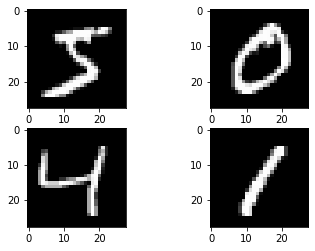

In [2]:
from keras.datasets import mnist

(X_train_num, y_train_num), (X_test_num, y_test_num) = mnist.load_data()

plt.subplot(221)
plt.imshow(X_train_num[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train_num[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train_num[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train_num[3], cmap=plt.get_cmap('gray'))

In [3]:
X_train_num

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [4]:
# Flatten the 28x28 images into a 784 vector for each image

num_pixels = X_train_num.shape[1] * X_train_num.shape[2]
X_train_num = X_train_num.reshape((X_train_num.shape[0], num_pixels)).astype('float32')
X_test_num = X_test_num.reshape((X_test_num.shape[0], num_pixels)).astype('float32')

# Normalize inputs from values of 0-255 to 0-1

X_train_num = X_train_num / 255
X_test_num = X_test_num / 255

X_train_num

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [5]:
X_test_num

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [6]:
# One-hot encode label values from integer to categorical

from keras.utils import np_utils

y_train_ohe = np_utils.to_categorical(y_train_num)
y_test_ohe = np_utils.to_categorical(y_test_num)

num_classes = y_test_ohe.shape[1]
num_classes

10

## K-Nearest Neighbors with Digits

In [7]:
# KNearest Neighbors
knn_digit = KNeighborsClassifier(n_jobs=3)
knn_digit.fit(X_train_num, y_train_ohe)

KNeighborsClassifier(n_jobs=3)

In [8]:
knn_digit_predicted = knn_digit.predict(X_test_num)

In [9]:
expected = y_test_ohe.tolist()
print('Accuracy: ', accuracy_score(expected, knn_digit_predicted))

Accuracy:  0.966


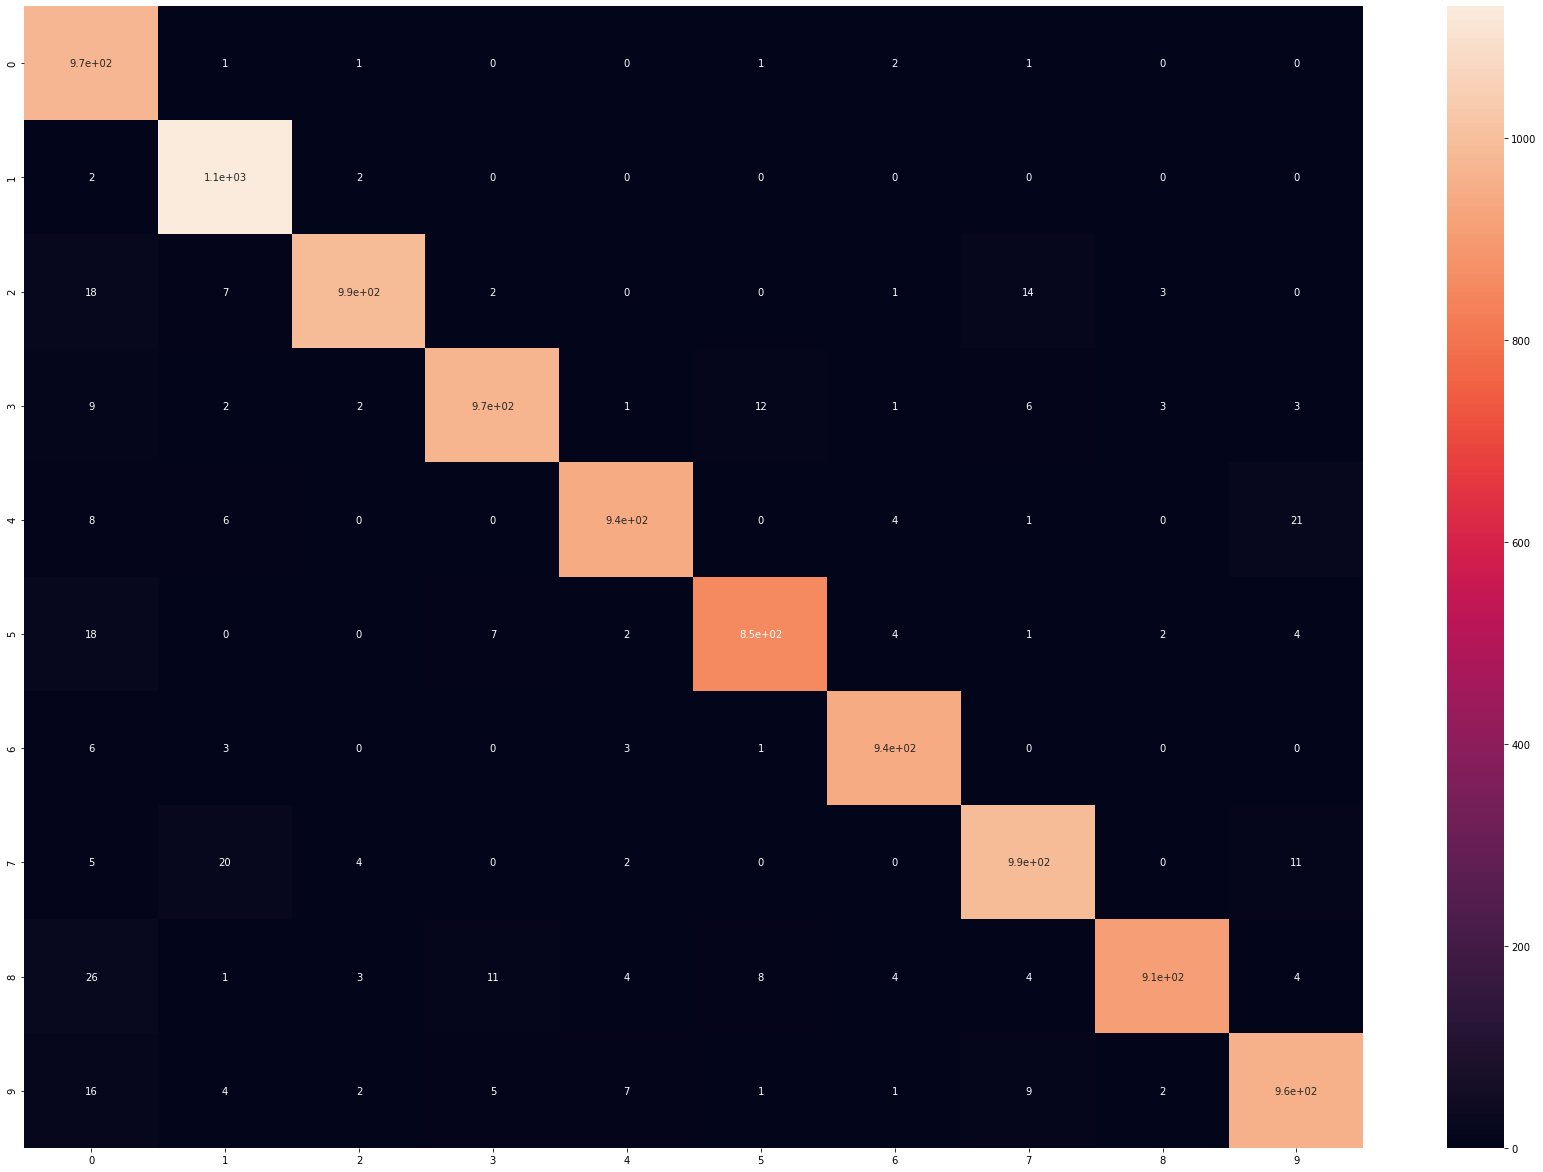

In [10]:
num_axis_labels = '0123456789'

create_confusion(y_test_ohe, knn_digit_predicted, num_axis_labels)

One-vs-One ROC AUC scores:
0.981361 (macro), 
0.981538 (weighted)

One-vs-Rest ROC AUC scores:
0.981361 (macro), 
0.981538 (weighted)


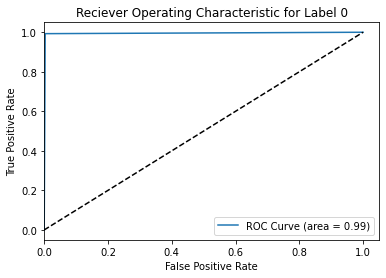

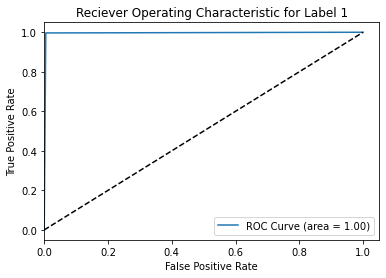

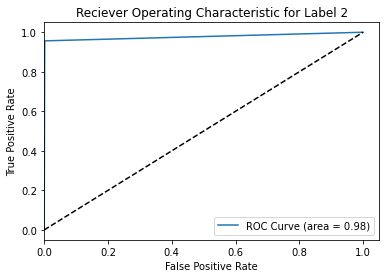

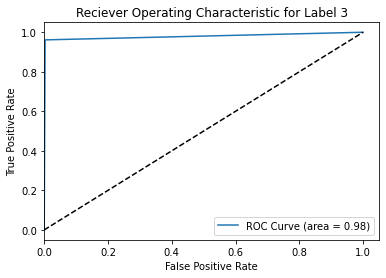

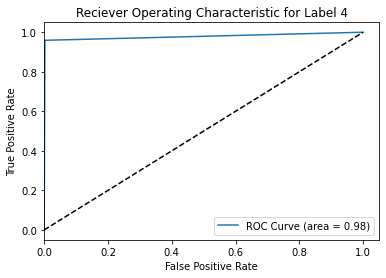

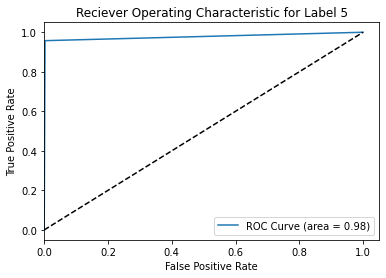

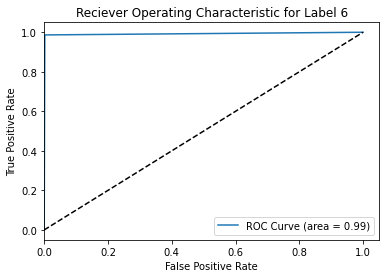

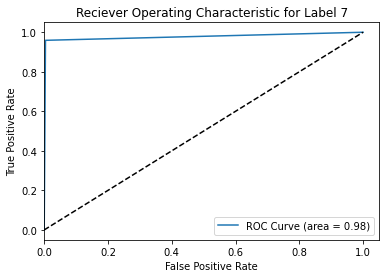

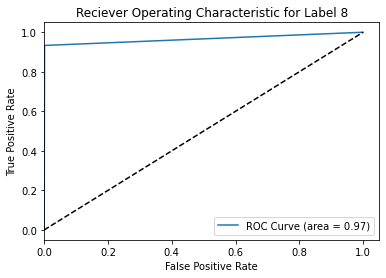

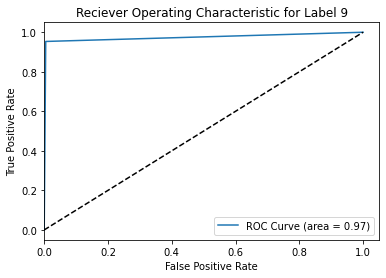

In [11]:
roc_auc(y_test_ohe, knn_digit_predicted, num_classes)

## Random Forest with Digits

In [12]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

random_forest_digit = RandomForestClassifier(n_estimators=100, n_jobs=3)
random_forest_digit.fit(X_train_num, y_train_ohe)

RandomForestClassifier(n_jobs=3)

In [13]:
forest_digit_predicted = random_forest_digit.predict(X_test_num)
print('Accuracy: ', accuracy_score(expected, forest_digit_predicted))

Accuracy:  0.9012


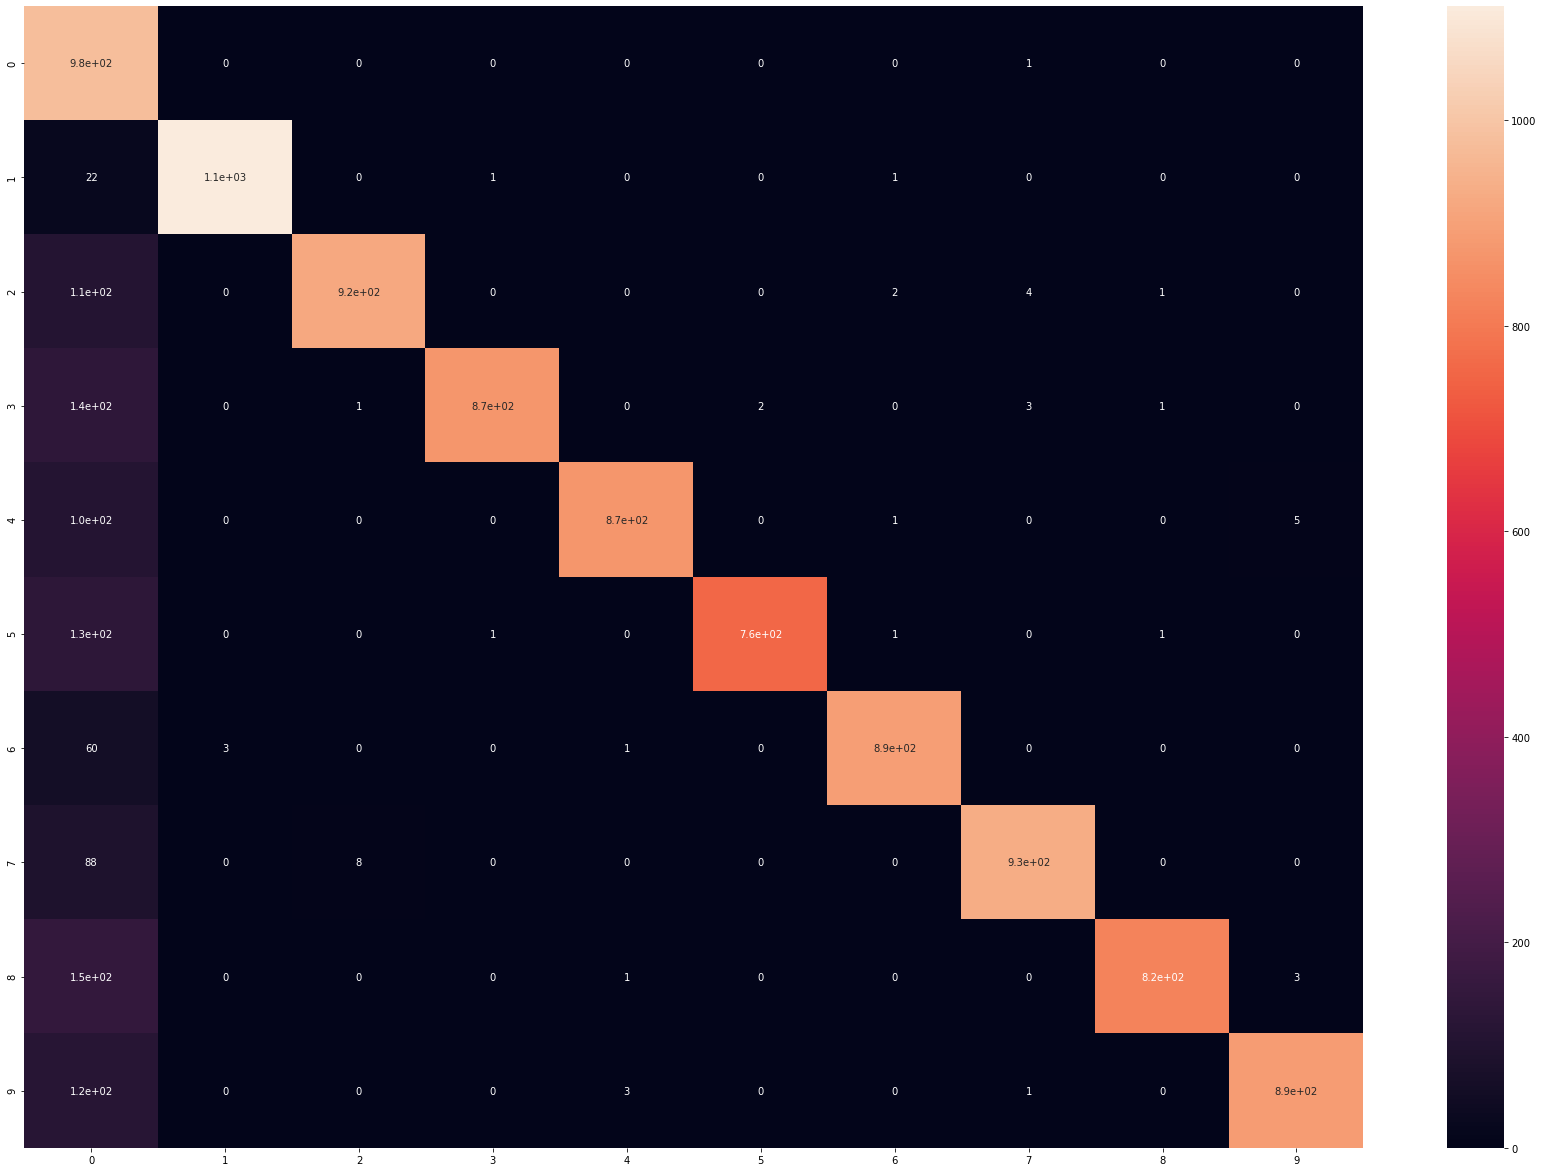

In [14]:
create_confusion(y_test_ohe, forest_digit_predicted, num_axis_labels)

One-vs-One ROC AUC scores:
0.949591 (macro), 
0.950309 (weighted)

One-vs-Rest ROC AUC scores:
0.949591 (macro), 
0.950309 (weighted)


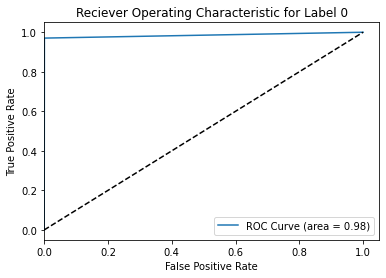

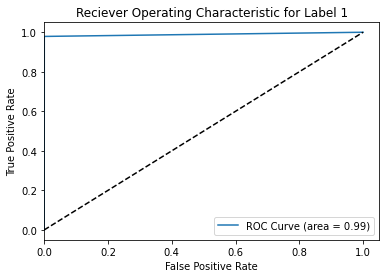

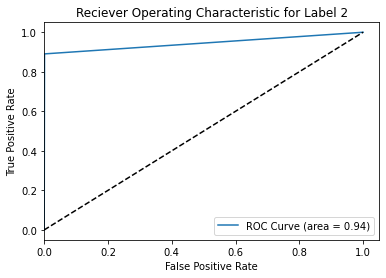

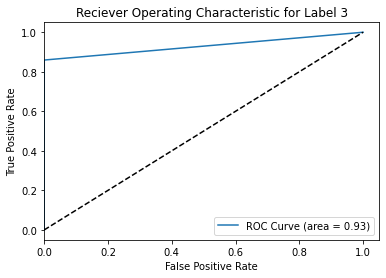

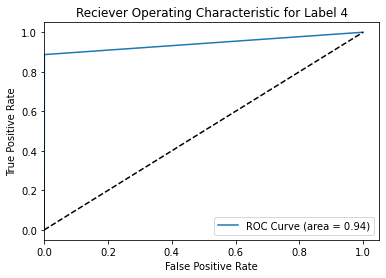

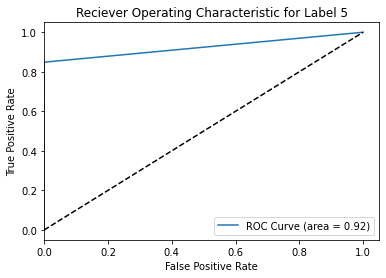

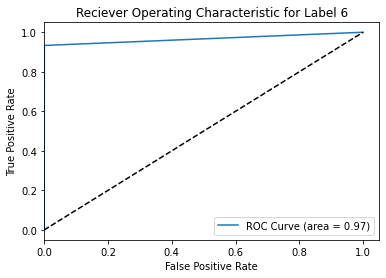

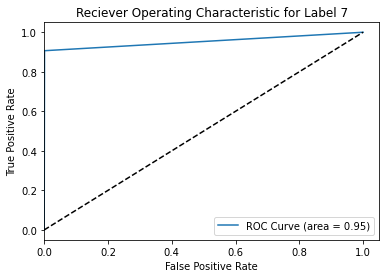

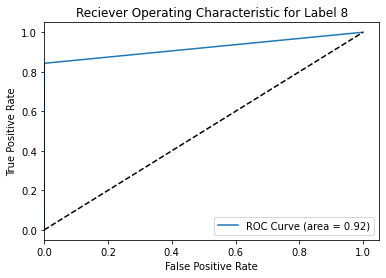

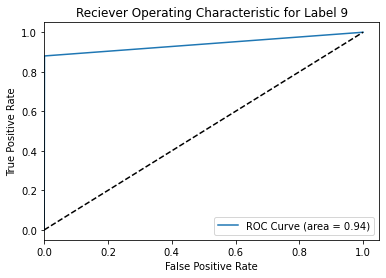

In [15]:
roc_auc(y_test_ohe, forest_digit_predicted, num_classes)

## Linear SVM with Digits

In [16]:
# Linear SVM (due to time consumption of using SVM with large dataset)

from sklearn.svm import LinearSVC

linear_svm_digit = LinearSVC(max_iter=10000)
linear_svm_digit.fit(X_train_num, y_train_num) # Does not take one-hot-encoded labels

LinearSVC(max_iter=10000)

In [17]:
linsvm_digit_predicted = linear_svm_digit.predict(X_test_num)
print('Accuracy: ', accuracy_score(np.argmax(expected, axis=1), linsvm_digit_predicted))

Accuracy:  0.9183


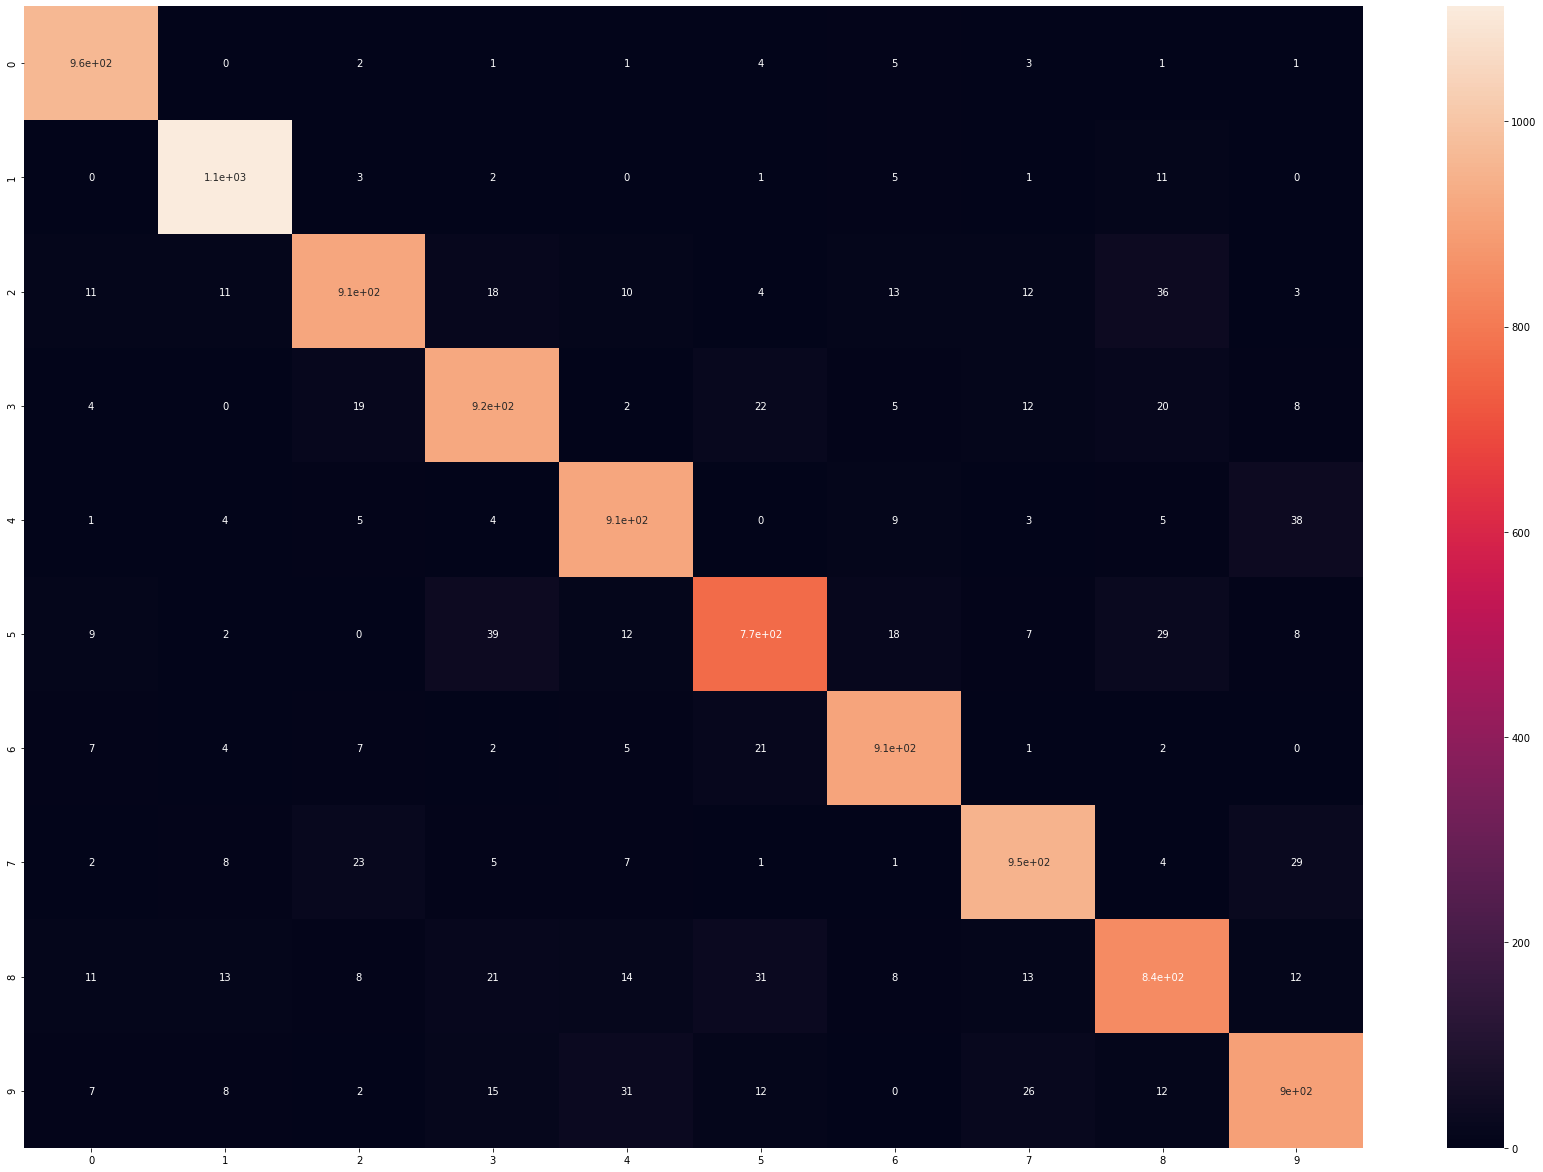

In [18]:
linsvm_predicted_ohe = np_utils.to_categorical(linsvm_digit_predicted)

create_confusion(y_test_ohe, linsvm_predicted_ohe, num_axis_labels)

One-vs-One ROC AUC scores:
0.954024 (macro), 
0.954644 (weighted)

One-vs-Rest ROC AUC scores:
0.954024 (macro), 
0.954644 (weighted)


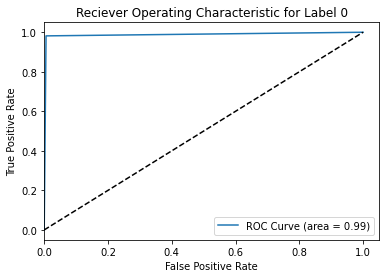

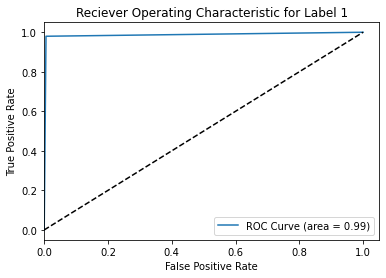

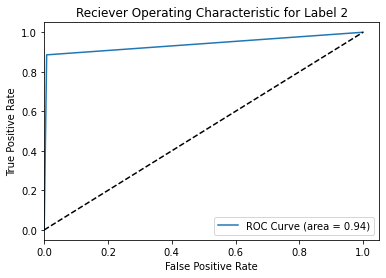

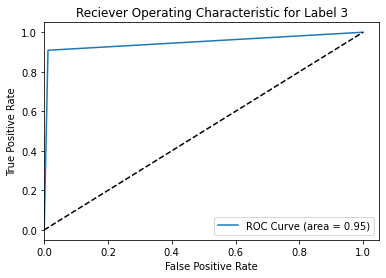

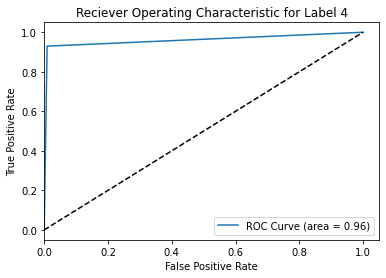

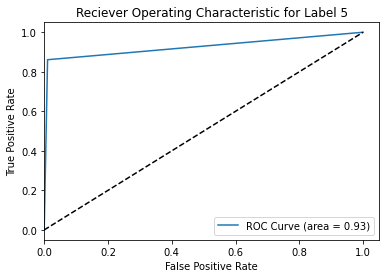

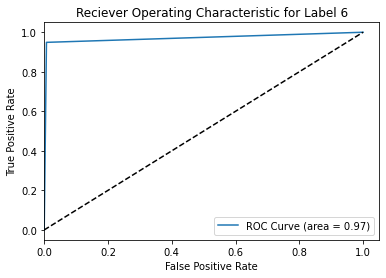

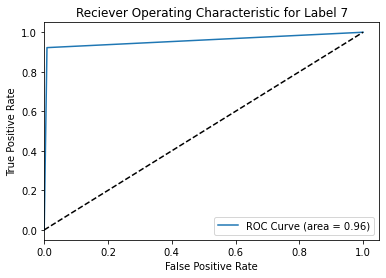

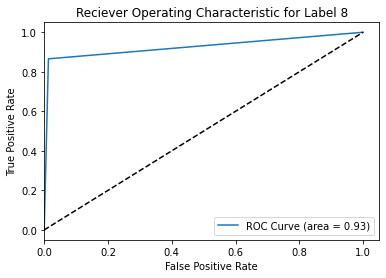

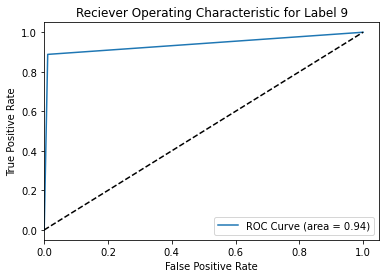

In [19]:
roc_auc(y_test_ohe, linsvm_predicted_ohe, num_classes)

## Logistic Regression with Digits

In [20]:
# Logistic Regression
logreg_digit = LogisticRegression(max_iter=1000, n_jobs=3)
logreg_digit.fit(X_train_num, y_train_num)

LogisticRegression(max_iter=1000, n_jobs=3)

In [21]:
logreg_digit_predicted = logreg_digit.predict(X_test_num)
print('Accuracy: ', accuracy_score(np.argmax(expected, axis=1), logreg_digit_predicted))

Accuracy:  0.9256


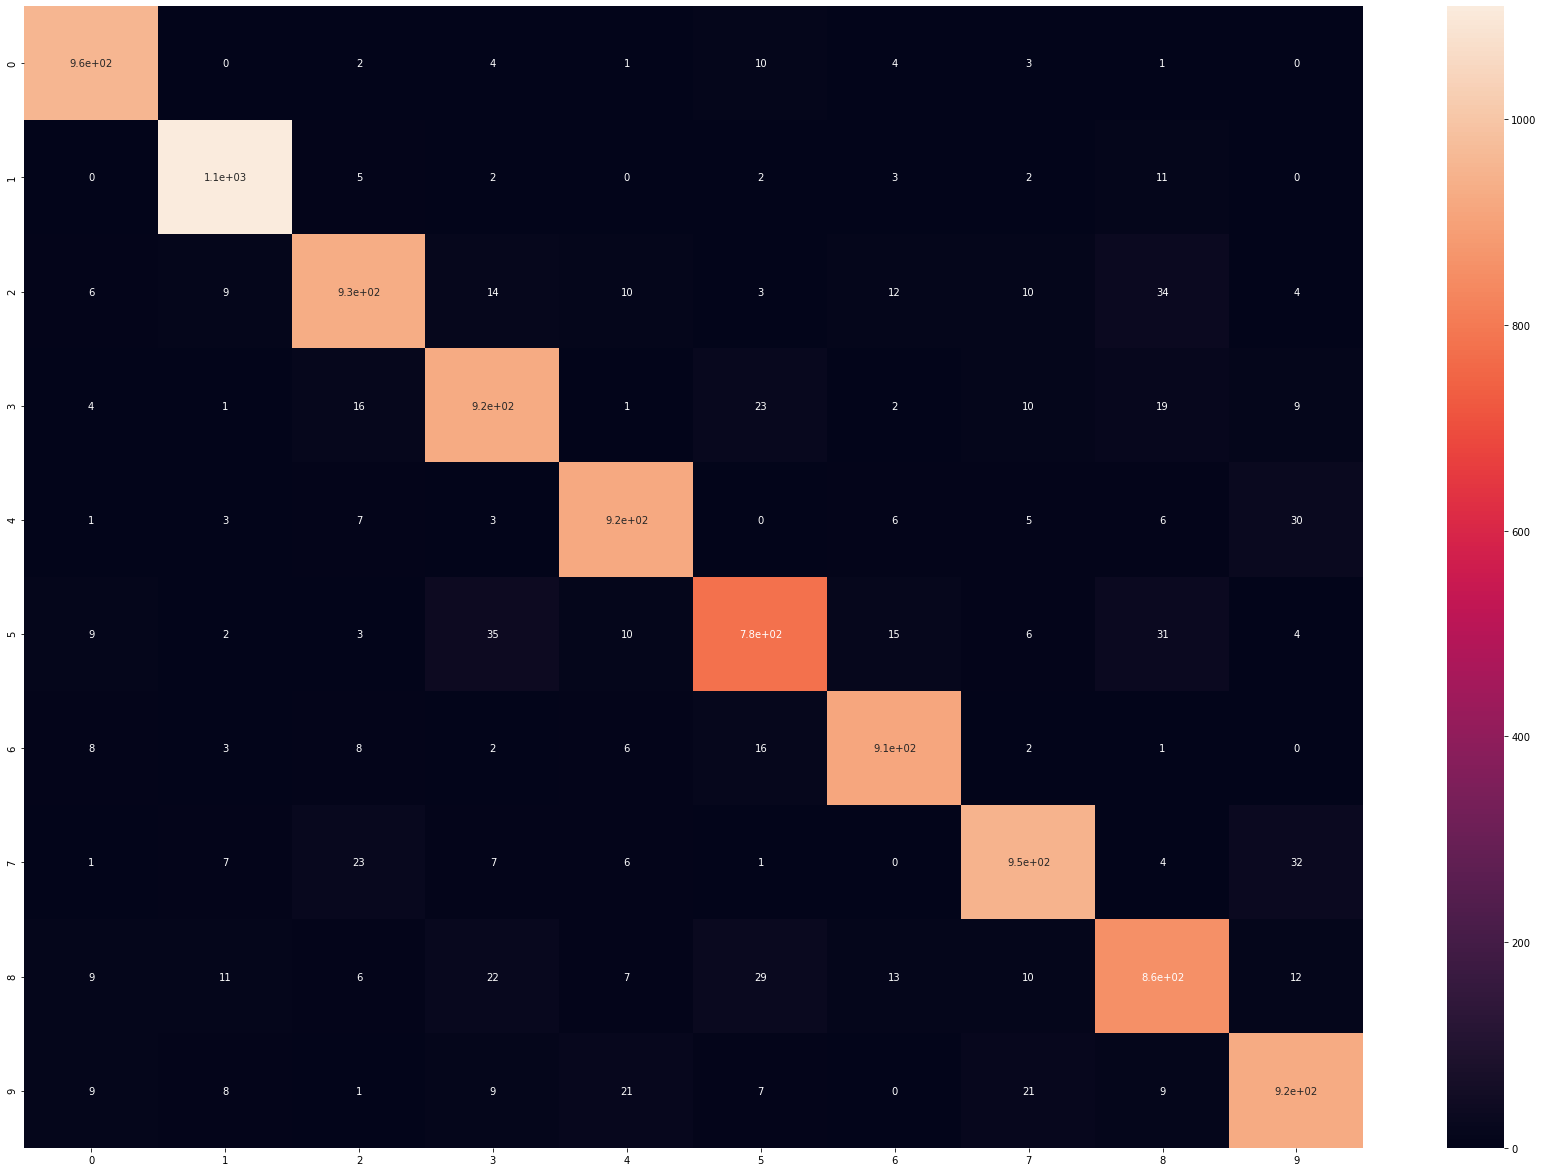

In [22]:
logreg_digit_predicted_ohe = np_utils.to_categorical(logreg_digit_predicted)

create_confusion(y_test_ohe, logreg_digit_predicted_ohe, num_axis_labels)

One-vs-One ROC AUC scores:
0.958130 (macro), 
0.958698 (weighted)

One-vs-Rest ROC AUC scores:
0.958130 (macro), 
0.958698 (weighted)


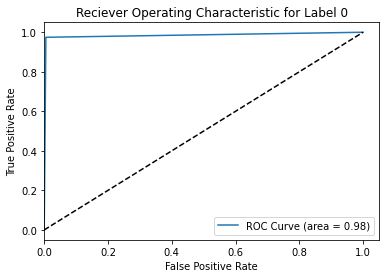

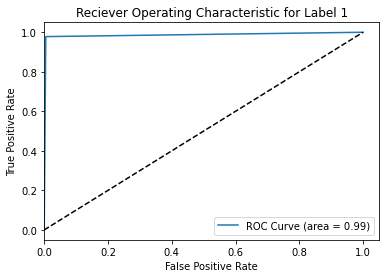

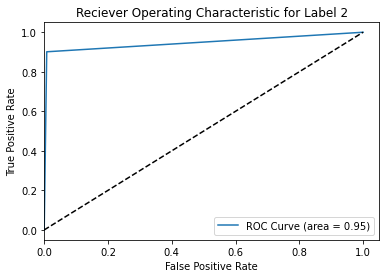

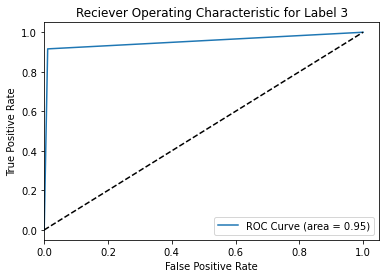

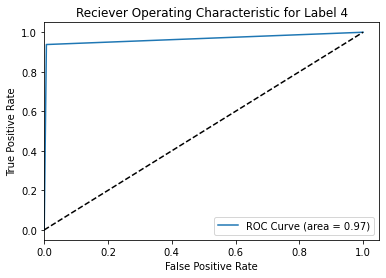

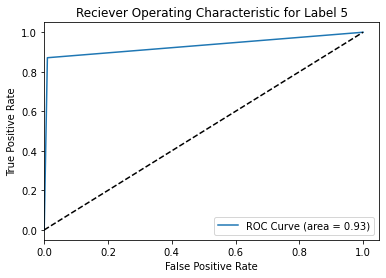

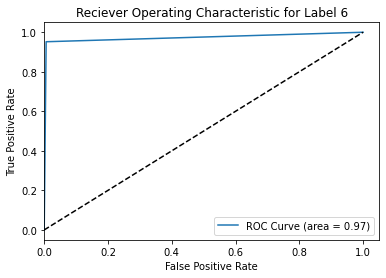

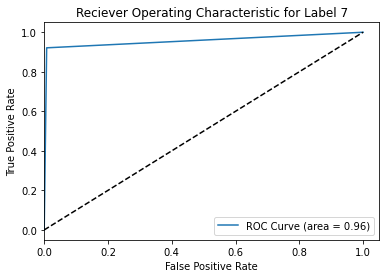

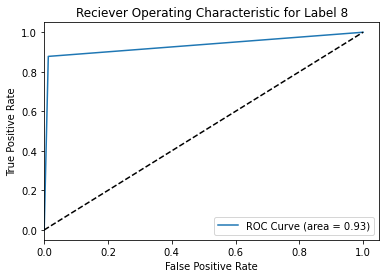

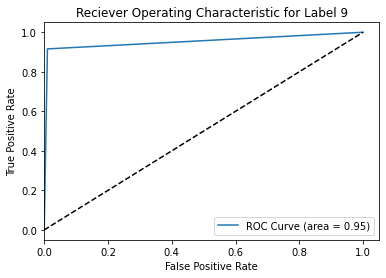

In [23]:
roc_auc(y_test_ohe, logreg_digit_predicted_ohe, num_classes)

## Simple Neural Network with Digits

In [24]:
# Simple Neural Network
def simple_nn(num_classes):
    model = Sequential()
    
    # Single hidden layer with neurons equivalent to number of pixels input
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    
    # Output Layer
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [25]:
digit_model = simple_nn(num_classes)
digit_model.fit(X_train_num, y_train_ohe, validation_data=(X_test_num, y_test_ohe), epochs=10, batch_size=200, verbose=2)

accuracy = digit_model.evaluate(X_test_num, y_test_ohe, verbose=0)
print('Accuracy: ', accuracy[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 3s - loss: 0.2828 - accuracy: 0.9203 - val_loss: 0.1398 - val_accuracy: 0.9591
Epoch 2/10
 - 3s - loss: 0.1121 - accuracy: 0.9676 - val_loss: 0.0969 - val_accuracy: 0.9700
Epoch 3/10
 - 3s - loss: 0.0720 - accuracy: 0.9785 - val_loss: 0.0776 - val_accuracy: 0.9771
Epoch 4/10
 - 3s - loss: 0.0500 - accuracy: 0.9859 - val_loss: 0.0653 - val_accuracy: 0.9807
Epoch 5/10
 - 3s - loss: 0.0355 - accuracy: 0.9901 - val_loss: 0.0626 - val_accuracy: 0.9809
Epoch 6/10
 - 3s - loss: 0.0265 - accuracy: 0.9927 - val_loss: 0.0652 - val_accuracy: 0.9799
Epoch 7/10
 - 3s - loss: 0.0202 - accuracy: 0.9949 - val_loss: 0.0618 - val_accuracy: 0.9811
Epoch 8/10
 - 3s - loss: 0.0151 - accuracy: 0.9963 - val_loss: 0.0589 - val_accuracy: 0.9822
Epoch 9/10
 - 3s - loss: 0.0116 - accuracy: 0.9973 - val_loss: 0.0664 - val_accuracy: 0.9808
Epoch 10/10
 - 3s - loss: 0.0080 - accuracy: 0.9983 - val_loss: 0.0583 - val_accuracy: 0.9822
Accuracy:  0.982200

In [26]:
nn_digit_predicted = digit_model.predict(X_test_num, batch_size=200, verbose=2)
print('Accuracy: ', accuracy_score(np.argmax(expected, axis=1), np.argmax(nn_digit_predicted, axis=1)))

Accuracy:  0.9822


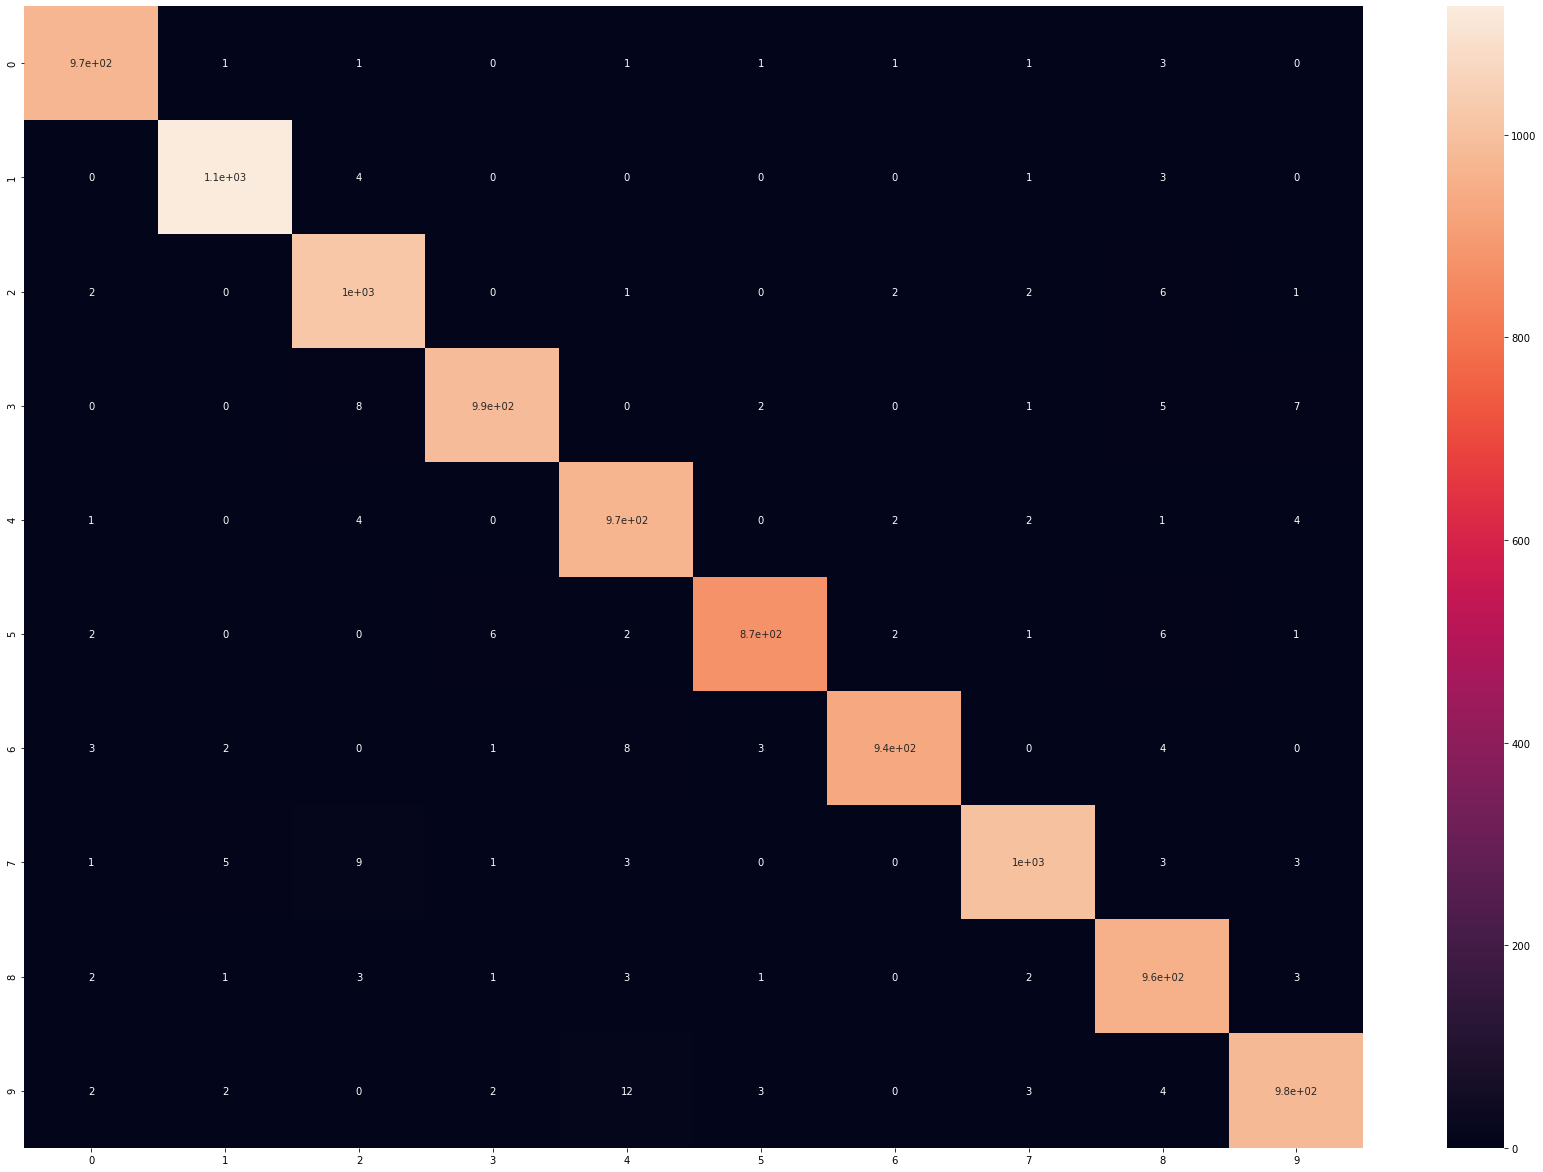

In [27]:
create_confusion(y_test_ohe, nn_digit_predicted, num_axis_labels)

One-vs-One ROC AUC scores:
0.999784 (macro), 
0.999784 (weighted)

One-vs-Rest ROC AUC scores:
0.999784 (macro), 
0.999784 (weighted)


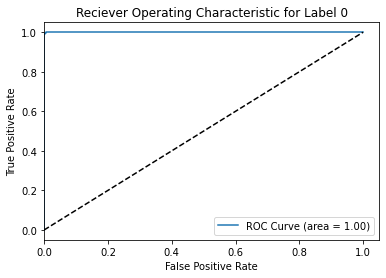

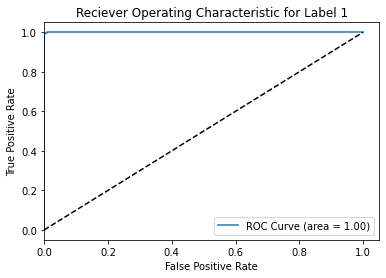

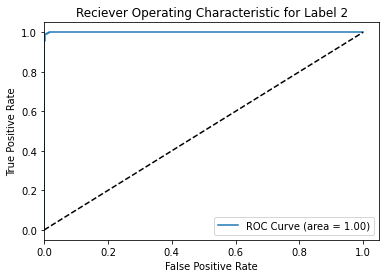

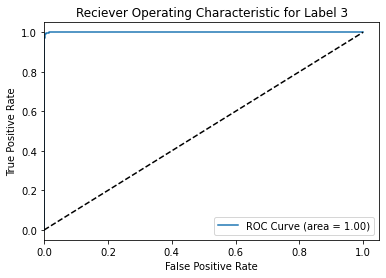

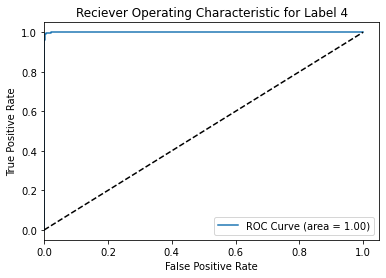

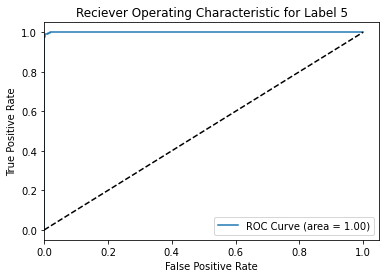

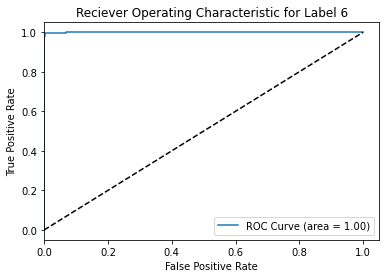

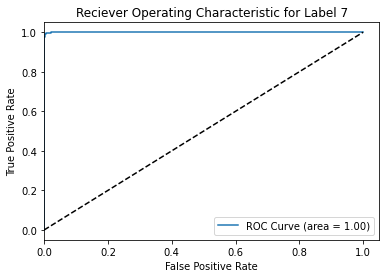

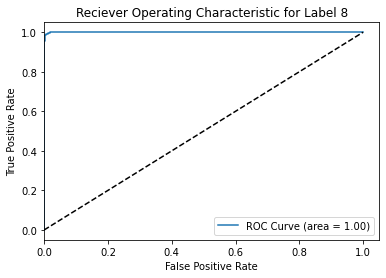

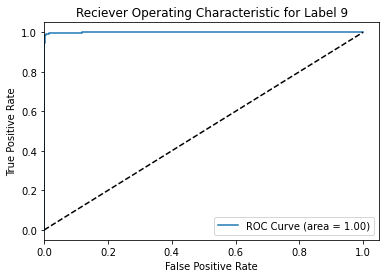

In [28]:
roc_auc(y_test_ohe, nn_digit_predicted, num_classes)

# Letter Data

In [29]:
letter_df = pd.read_csv('emnist-letters-train.csv')
letter_df

23  0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  ...  0.406  0.407  \
0       7  0    0    0    0    0    0    0    0    0  ...      0      0   
1      16  0    0    0    0    0    0    0    0    0  ...      0      0   
2      15  0    0    0    0    0    0    0    0    0  ...      0      0   
3      23  0    0    0    0    0    0    0    0    0  ...      0      0   
4      17  0    0    0    0    0    0    0    0    0  ...      0      0   
...    .. ..  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
88794   1  0    0    0    0    0    0    0    0    0  ...      0      0   
88795  21  0    0    0    0    0    0    0    0    0  ...      0      0   
88796   1  0    0    0    0    0    0    0    0    0  ...      0      0   
88797  23  0    0    0    0    0    0    0    0    0  ...      0      0   
88798  12  0    0    0    0    0    0    0    0    0  ...      0      0   

       0.408  0.409  0.410  0.411  0.412  0.413  0.414  0.415  
0          0      0      0      0      0      0      0      0  
1          0      0      0      0      0      0      0      0  
2          0      0      0      0      0      0      0      0  
3          0      0      0      0      0      0      0      0  
4          0      0      0      0      0      0      0      0  
...      ...    ...    ...    ...    ...    ...    ...    ...  
88794      0      0      0      0      0      0      0      0  
88795      0      0      0      0      0      0      0      0  
88796      0      0      0      0      0      0      0      0  
88797      0      0      0      0      0      0      0      0  
88798      0      0      0      0      0      0      0      0  

[88799 rows x 785 columns]

In [30]:
letter_df = letter_df.rename(columns={'23': 'Label'})
a = letter_df.columns[np.arange(1, 785)]
b = [i for i in range(len(a))]
d = dict(zip(a, b))
letter_df = letter_df.rename(columns=d)
letter_df

Label  0  1  2  3  4  5  6  7  8  ...  774  775  776  777  778  779  \
0          7  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
1         16  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
2         15  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
3         23  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
4         17  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
...      ... .. .. .. .. .. .. .. .. ..  ...  ...  ...  ...  ...  ...  ...   
88794      1  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
88795     21  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
88796      1  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
88797     23  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
88798     12  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   

       780  781  782  783  
0        0    0    0    0  
1        0    0    0    0  
2        0    0    0    0  
3        0    0    0    0  
4        0    0    0    0  
...    ...  ...  ...  ...  
88794    0    0    0    0  
88795    0    0    0    0  
88796    0    0    0    0  
88797    0    0    0    0  
88798    0    0    0    0  

[88799 rows x 785 columns]

In [31]:
np.unique(letter_df['Label'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26], dtype=int64)

In [32]:
# Make letter labels correspond to 0-25
letter_df['Label'] = letter_df['Label'] - 1

np.unique(letter_df['Label'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int64)

In [33]:
y_letter = letter_df['Label']
X_letter = letter_df.drop(['Label'], axis=1)

y_letter

0         6
1        15
2        14
3        22
4        16
         ..
88794     0
88795    20
88796     0
88797    22
88798    11
Name: Label, Length: 88799, dtype: int64

In [34]:
X_letter_shape = []

for item in np.array(X_letter):
    X_letter_shape.append(item.reshape([28,28]))

X_letter_transpose = []

for image in X_letter_shape:
    X_letter_transpose.append(image.T)
    
X_letter2 = []

for item in X_letter_transpose:
    X_letter2.append(item.reshape([784]))
    
X_letter = np.array(X_letter2)

In [35]:
from sklearn.model_selection import train_test_split
X_train_letter, X_test_letter, y_train_letter, y_test_letter = train_test_split(X_letter, y_letter, test_size=.33)

X_train_letter

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [36]:
y_train_letter

1332      5
37190     0
66214     3
11957    23
26515    14
         ..
11962    19
55487    21
30381    13
6516      9
13668    21
Name: Label, Length: 59495, dtype: int64

In [37]:
X_test_letter

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [38]:
y_test_letter

86956     8
56677    13
25182    17
29367    16
3257      5
         ..
37943    15
13891     5
48684    15
8194     13
81438     4
Name: Label, Length: 29304, dtype: int64

In [39]:
#X_train_letter = np.array(X_train_letter.iloc[:, 0:].values)
y_train_letter = np.array(y_train_letter)

#X_test_letter = np.array(X_test_letter.iloc[:, 0:].values)
y_test_letter = np.array(y_test_letter)

X_train_letter = X_train_letter / 255
X_test_letter = X_test_letter / 255

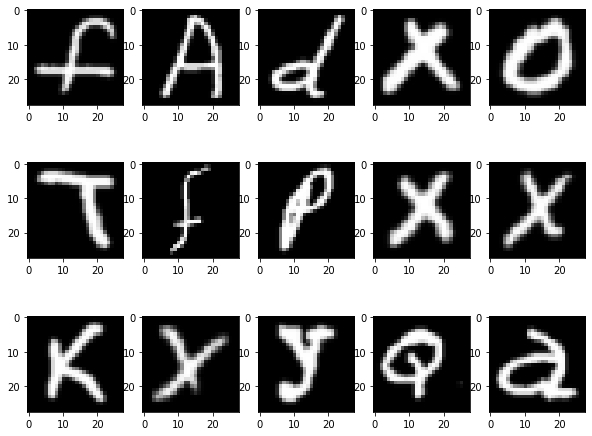

In [40]:
fig, axes = plt.subplots(3, 5, figsize=(10,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_letter[i].reshape([28,28]), cmap=plt.get_cmap('gray'))

In [41]:
num_classes = 26
y_train_letter_ohe = np_utils.to_categorical(y_train_letter, num_classes)
y_test_letter_ohe = np_utils.to_categorical(y_test_letter, num_classes)

In [42]:
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
              'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

y_train_letter2 = []
y_test_letter2 = []

for number in y_train_letter:
    y_train_letter2.append(letters[number])
    
for number in y_test_letter:
    y_test_letter2.append(letters[number])

y_train_letter2

['F',
 'A',
 'D',
 'X',
 'O',
 'T',
 'F',
 'P',
 'X',
 'X',
 'K',
 'X',
 'Y',
 'Q',
 'A',
 'Y',
 'U',
 'I',
 'F',
 'M',
 'U',
 'H',
 'J',
 'R',
 'G',
 'L',
 'U',
 'E',
 'J',
 'I',
 'Y',
 'S',
 'P',
 'W',
 'X',
 'H',
 'N',
 'Z',
 'G',
 'K',
 'I',
 'D',
 'R',
 'M',
 'H',
 'N',
 'Z',
 'P',
 'F',
 'R',
 'V',
 'T',
 'C',
 'M',
 'W',
 'R',
 'K',
 'I',
 'Y',
 'P',
 'J',
 'N',
 'W',
 'G',
 'J',
 'A',
 'L',
 'S',
 'B',
 'J',
 'L',
 'V',
 'W',
 'X',
 'L',
 'S',
 'A',
 'S',
 'V',
 'I',
 'G',
 'U',
 'T',
 'K',
 'C',
 'Y',
 'R',
 'E',
 'X',
 'H',
 'U',
 'I',
 'I',
 'X',
 'P',
 'U',
 'F',
 'M',
 'E',
 'M',
 'I',
 'K',
 'Q',
 'A',
 'J',
 'H',
 'K',
 'L',
 'N',
 'R',
 'P',
 'Y',
 'T',
 'Z',
 'D',
 'S',
 'D',
 'O',
 'G',
 'U',
 'B',
 'A',
 'F',
 'V',
 'K',
 'H',
 'O',
 'A',
 'E',
 'M',
 'V',
 'S',
 'N',
 'R',
 'M',
 'O',
 'X',
 'I',
 'L',
 'W',
 'X',
 'Y',
 'R',
 'R',
 'W',
 'N',
 'R',
 'O',
 'A',
 'V',
 'R',
 'P',
 'H',
 'R',
 'E',
 'M',
 'X',
 'B',
 'Q',
 'L',
 'Y',
 'J',
 'Y',
 'M',
 'S',
 'E',
 'Y'

## K-Nearest Neighbors with Letters

In [43]:
knn_letter = KNeighborsClassifier(n_jobs=3)
knn_letter.fit(X_train_letter, y_train_letter2)

KNeighborsClassifier(n_jobs=3)

In [44]:
knn_letter_predicted = knn_letter.predict(X_test_letter)

In [45]:
print('Accuracy: ', accuracy_score(y_test_letter2, knn_letter_predicted))

Accuracy:  0.8430930930930931


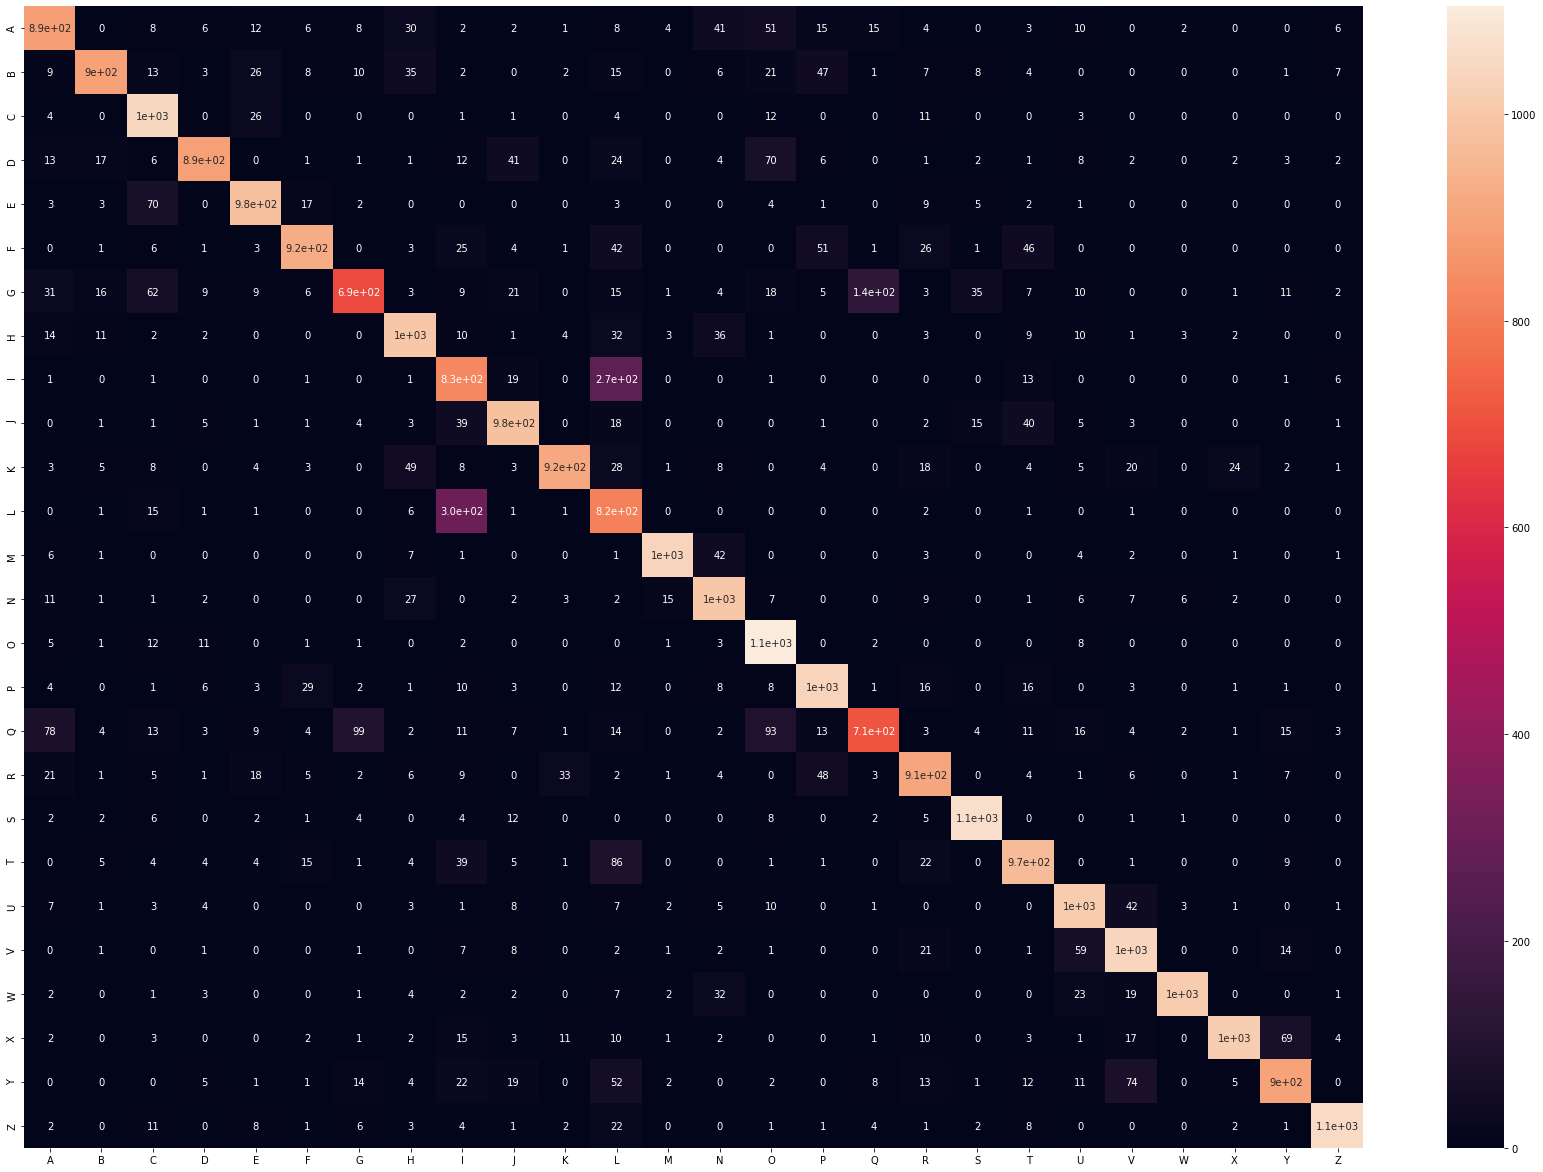

In [46]:
letter_axis_labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

create_confusion(y_test_letter2, knn_letter_predicted, letter_axis_labels)

C:\Users\Patrick\anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


One-vs-One ROC AUC scores:
0.918414 (macro), 
0.918393 (weighted)

One-vs-Rest ROC AUC scores:
0.918414 (macro), 
0.918393 (weighted)


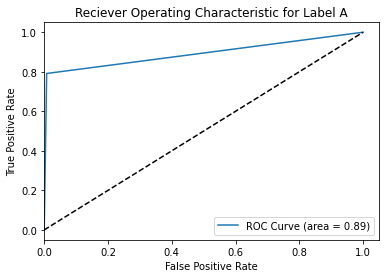

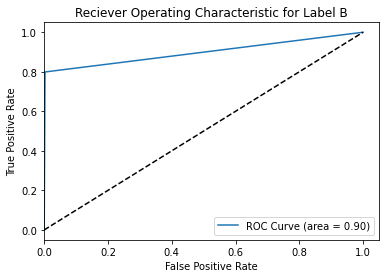

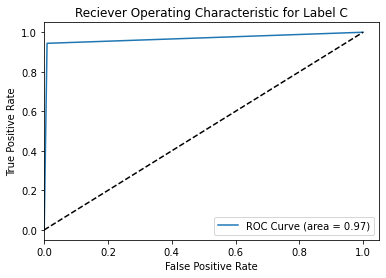

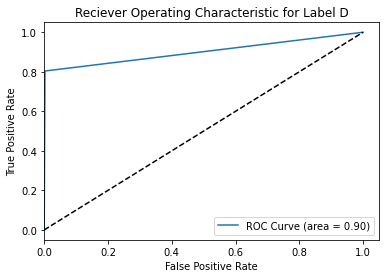

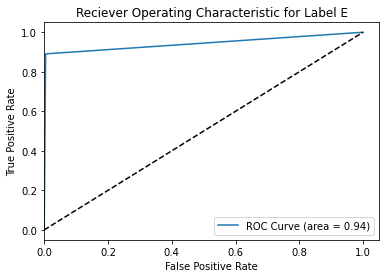

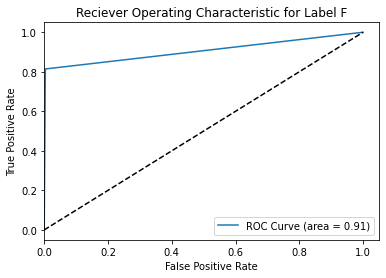

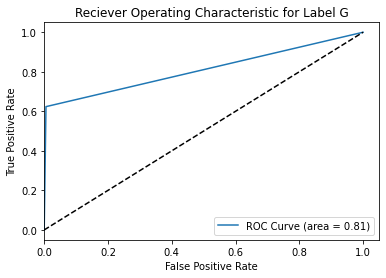

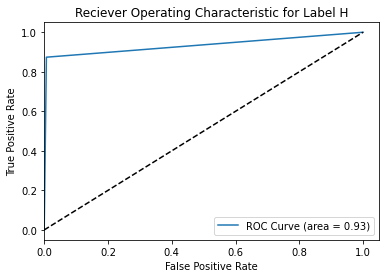

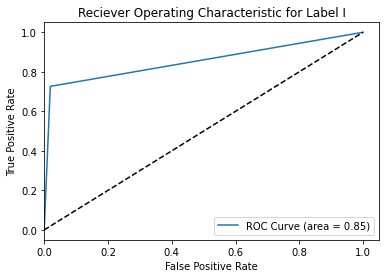

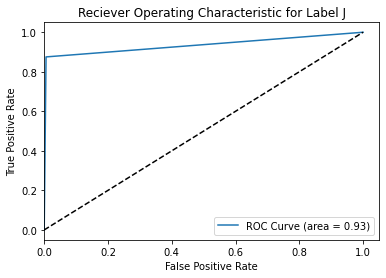

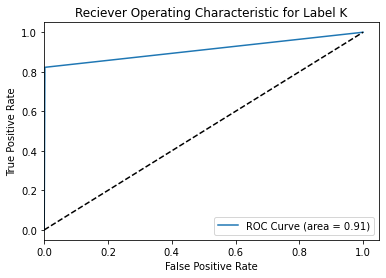

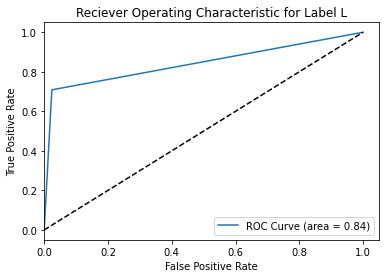

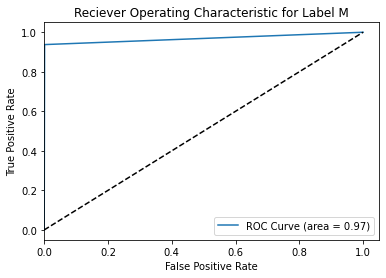

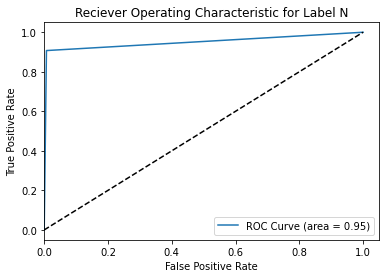

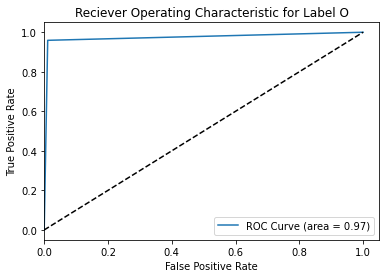

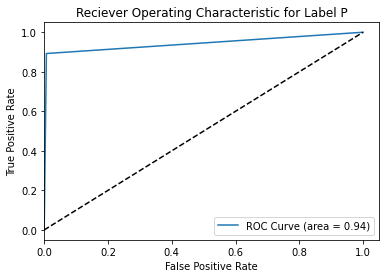

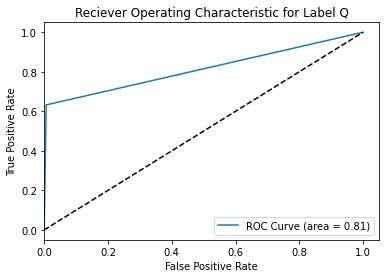

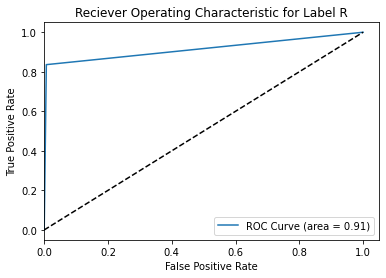

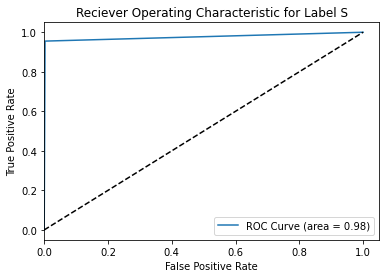

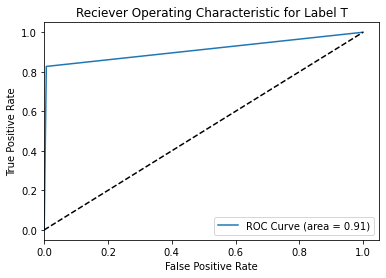

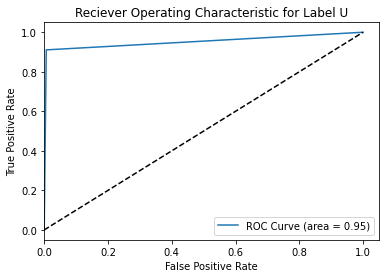

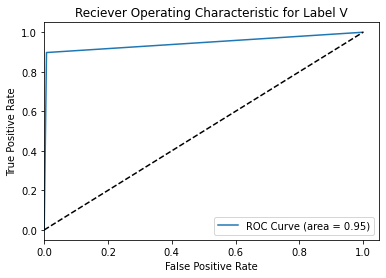

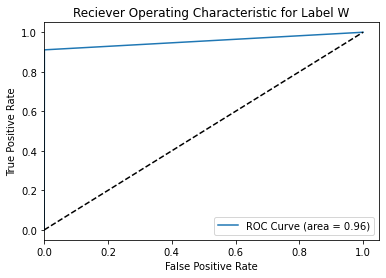

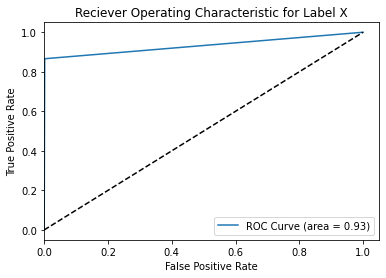

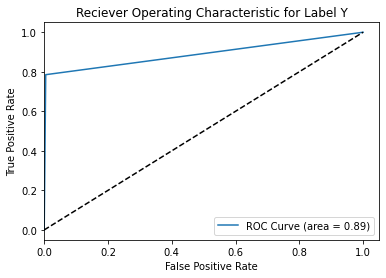

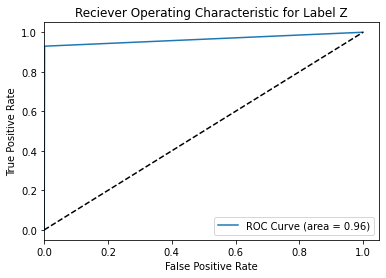

In [47]:
knn_letter_categorical = []

# Get ASCII for each character and subtract 65 in order to make range 0-25
for letter in knn_letter_predicted:
    knn_letter_categorical.append(ord(letter) - 65)

knn_letter_categorical = np_utils.to_categorical(knn_letter_categorical)

roc_auc(y_test_letter_ohe, knn_letter_categorical, num_classes)

## Logistic Regression with Letters

In [48]:
logreg_letter = LogisticRegression(max_iter=10000, n_jobs=3)
logreg_letter.fit(X_train_letter, y_train_letter2)

LogisticRegression(max_iter=10000, n_jobs=3)

In [49]:
logreg_letter_predicted = logreg_letter.predict(X_test_letter)
print('Accuracy: ', accuracy_score(y_test_letter2, logreg_letter_predicted))

Accuracy:  0.706012831012831


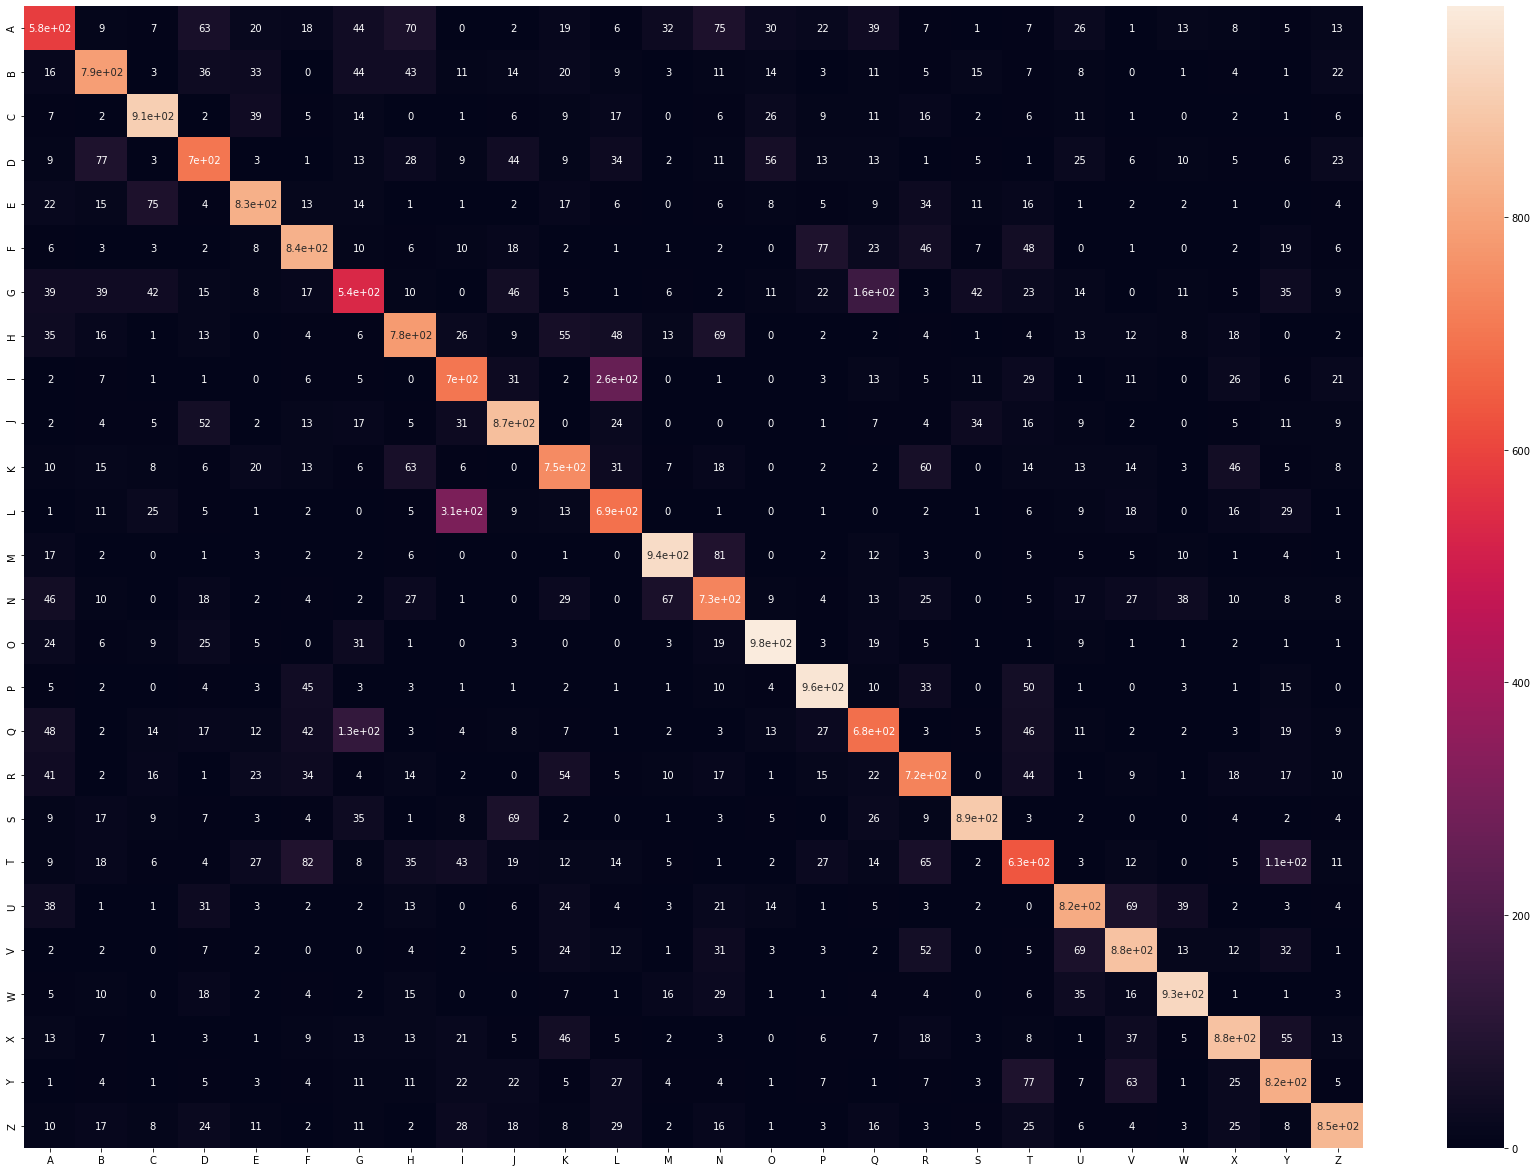

In [50]:
#logreg_letter_predicted_ohe = np_utils.to_categorical(logreg_letter_predicted)

create_confusion(y_test_letter2, logreg_letter_predicted, letter_axis_labels)

C:\Users\Patrick\anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


One-vs-One ROC AUC scores:
0.847088 (macro), 
0.847123 (weighted)

One-vs-Rest ROC AUC scores:
0.847088 (macro), 
0.847123 (weighted)


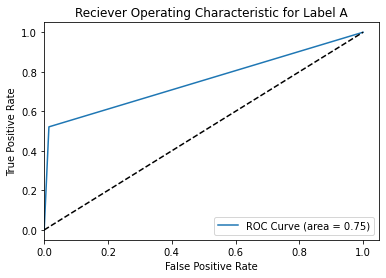

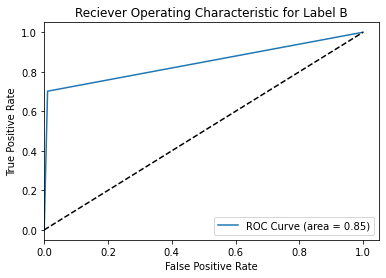

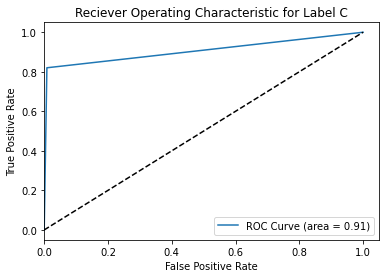

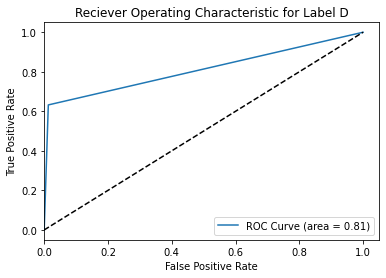

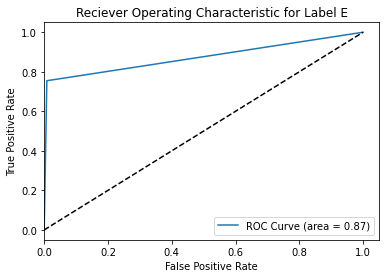

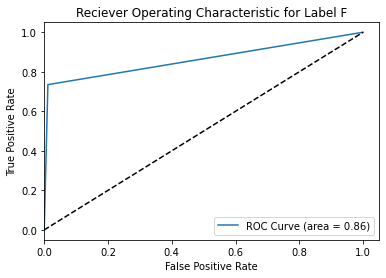

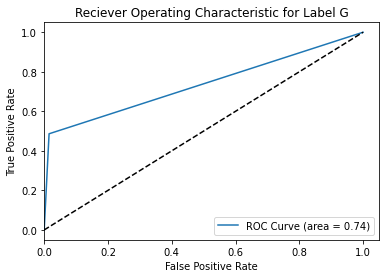

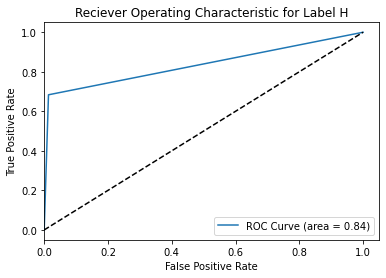

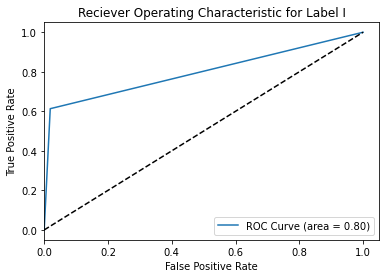

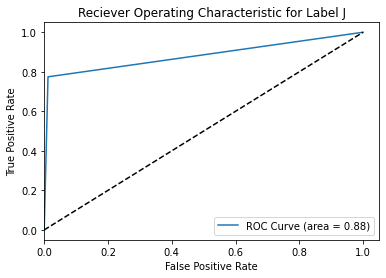

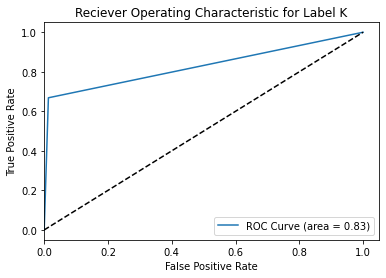

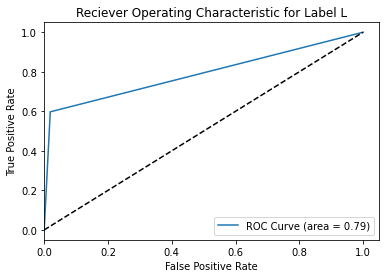

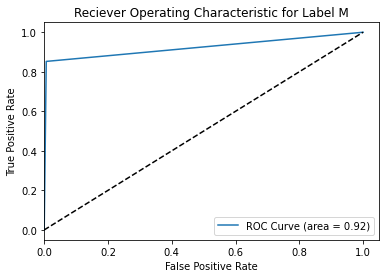

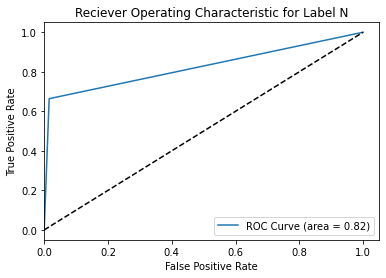

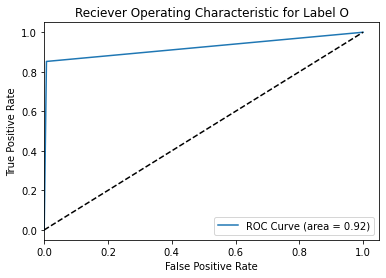

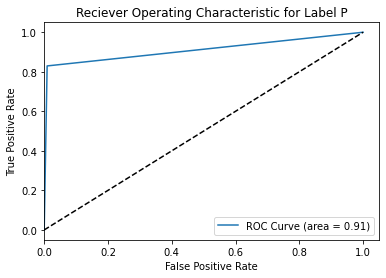

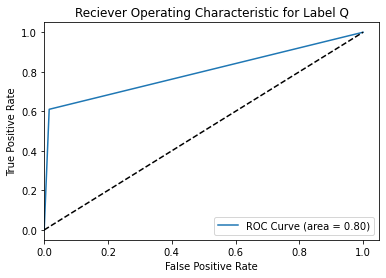

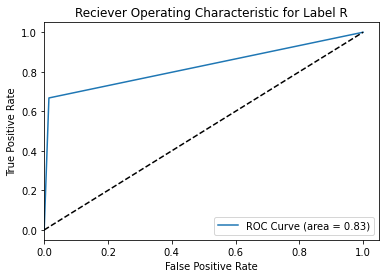

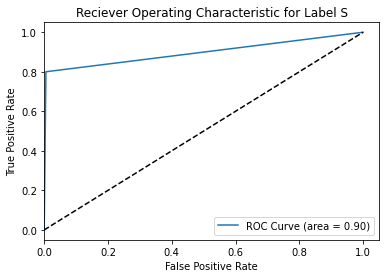

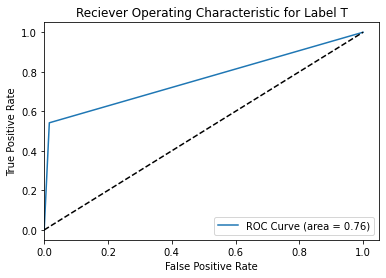

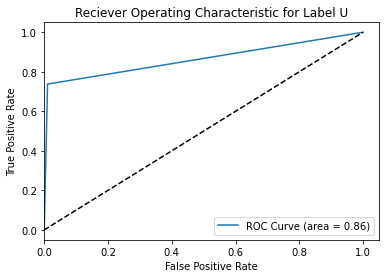

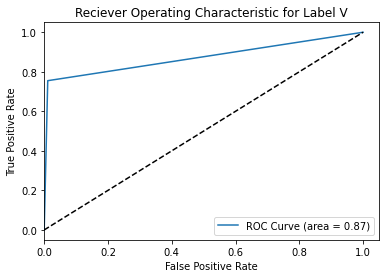

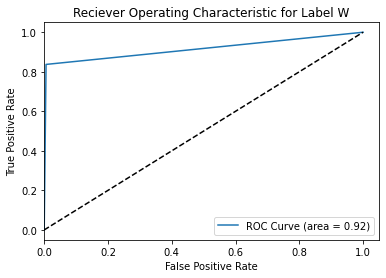

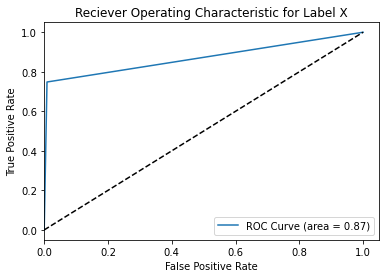

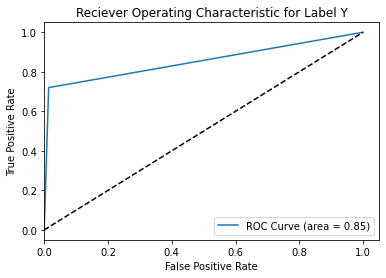

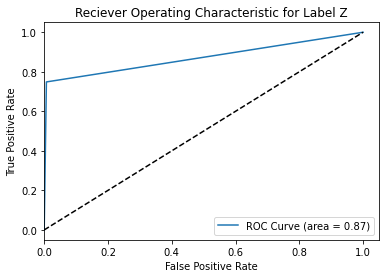

In [51]:
logreg_letter_categorical = []

# Get ASCII for each character and subtract 65 in order to make range 0-25
for letter in logreg_letter_predicted:
    logreg_letter_categorical.append(ord(letter) - 65)

logreg_letter_categorical = np_utils.to_categorical(logreg_letter_categorical)

roc_auc(y_test_letter_ohe, logreg_letter_categorical, num_classes)

## Simple Neural Network with Letters

In [52]:
letter_model = simple_nn(num_classes)
letter_model.fit(X_train_letter, y_train_letter_ohe, validation_data=(X_test_letter, y_test_letter_ohe), 
          epochs=10, batch_size=200, verbose=2)

accuracy = letter_model.evaluate(X_test_letter, y_test_letter_ohe, verbose=0)
print('Accuracy: ', accuracy[1])

Train on 59495 samples, validate on 29304 samples
Epoch 1/10
 - 4s - loss: 0.9451 - accuracy: 0.7295 - val_loss: 0.6289 - val_accuracy: 0.8140
Epoch 2/10
 - 4s - loss: 0.4852 - accuracy: 0.8559 - val_loss: 0.4689 - val_accuracy: 0.8562
Epoch 3/10
 - 4s - loss: 0.3649 - accuracy: 0.8876 - val_loss: 0.4053 - val_accuracy: 0.8750
Epoch 4/10
 - 4s - loss: 0.3011 - accuracy: 0.9054 - val_loss: 0.3596 - val_accuracy: 0.8876
Epoch 5/10
 - 4s - loss: 0.2554 - accuracy: 0.9197 - val_loss: 0.3559 - val_accuracy: 0.8883
Epoch 6/10
 - 4s - loss: 0.2241 - accuracy: 0.9276 - val_loss: 0.3347 - val_accuracy: 0.8965
Epoch 7/10
 - 4s - loss: 0.1940 - accuracy: 0.9360 - val_loss: 0.3411 - val_accuracy: 0.8937
Epoch 8/10
 - 4s - loss: 0.1720 - accuracy: 0.9437 - val_loss: 0.3380 - val_accuracy: 0.8947
Epoch 9/10
 - 4s - loss: 0.1532 - accuracy: 0.9497 - val_loss: 0.3297 - val_accuracy: 0.8982
Epoch 10/10
 - 4s - loss: 0.1379 - accuracy: 0.9537 - val_loss: 0.3300 - val_accuracy: 0.8986
Accuracy:  0.898580

In [53]:
nn_letter_predicted = letter_model.predict(X_test_letter, batch_size=200, verbose=2)
print('Accuracy: ', accuracy_score(y_test_letter, np.argmax(nn_letter_predicted, axis=1)))

Accuracy:  0.8985803985803986


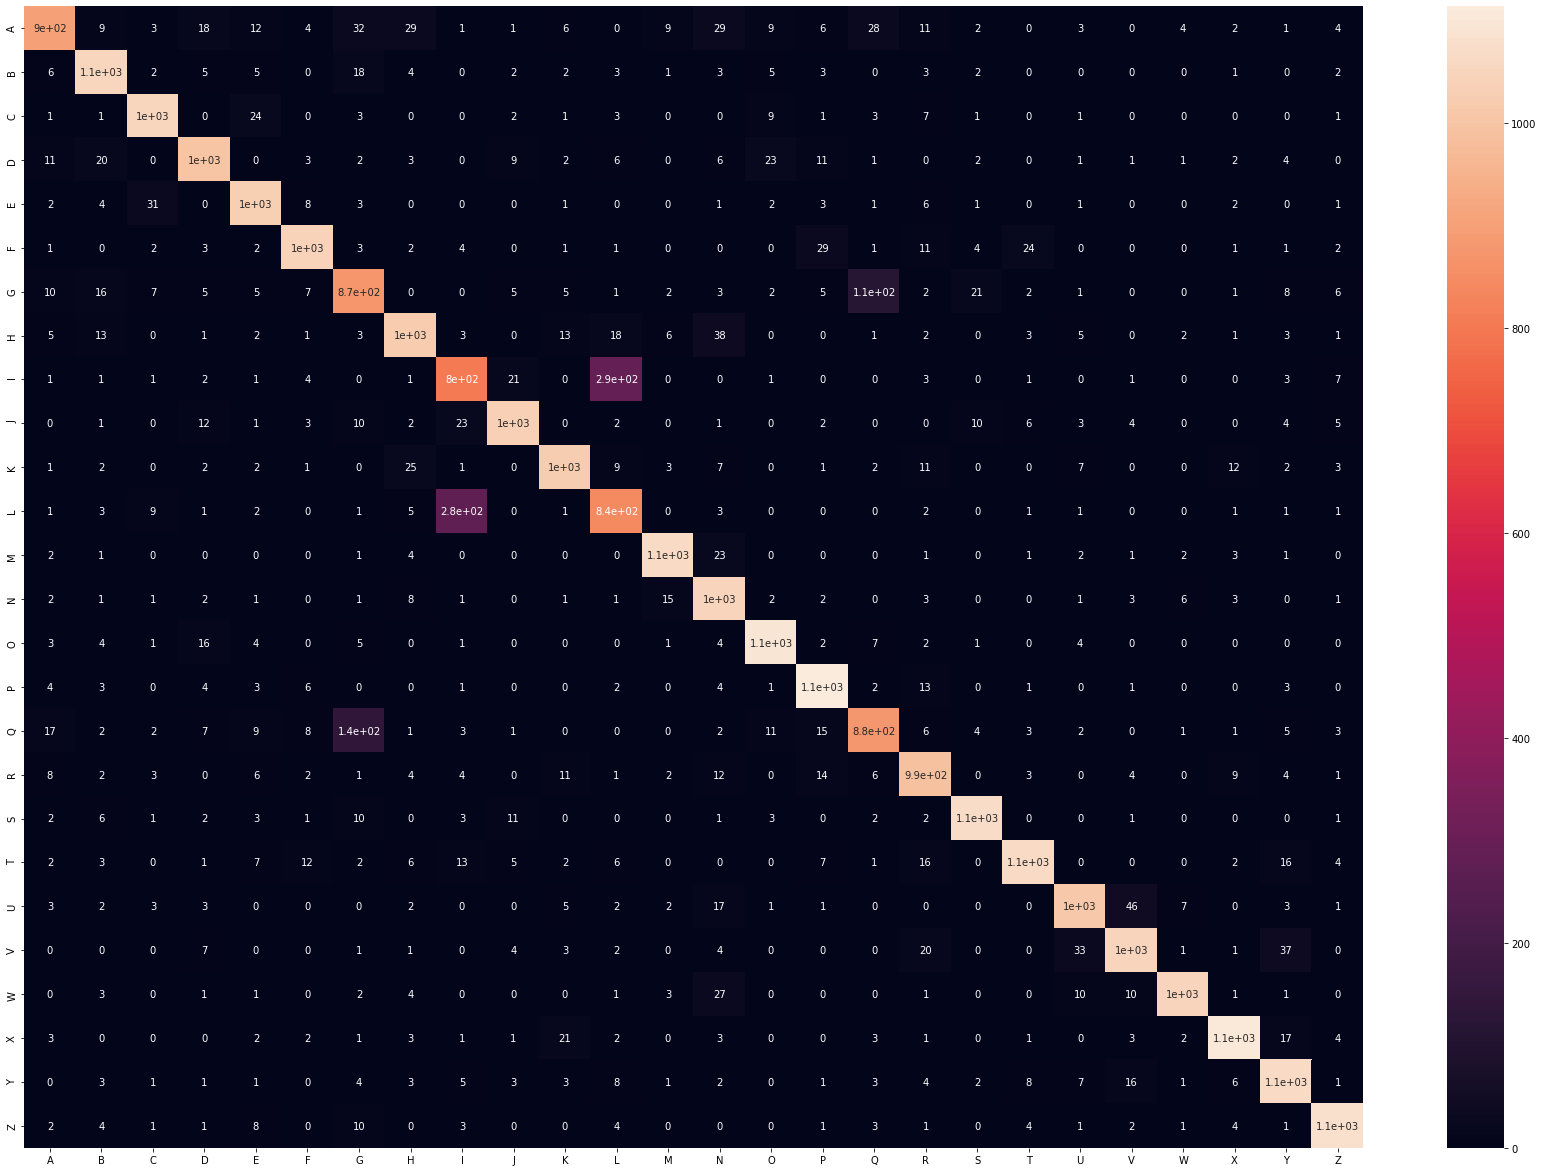

In [54]:
create_confusion(y_test_letter_ohe, nn_letter_predicted, letter_axis_labels)

C:\Users\Patrick\anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


One-vs-One ROC AUC scores:
0.996727 (macro), 
0.996730 (weighted)

One-vs-Rest ROC AUC scores:
0.996727 (macro), 
0.996730 (weighted)


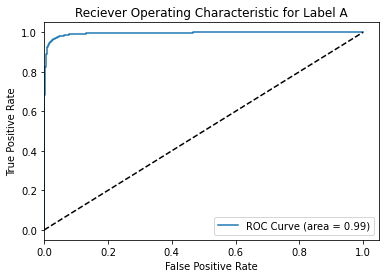

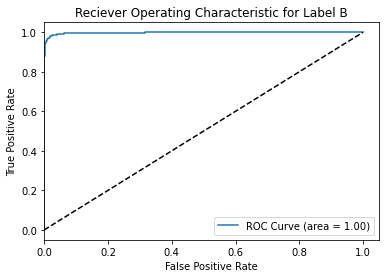

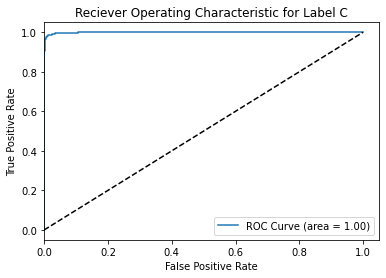

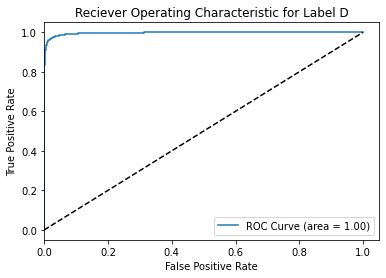

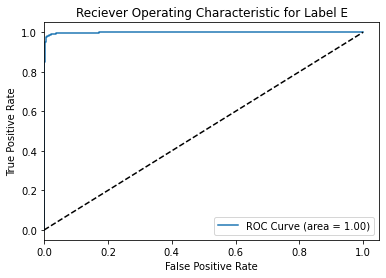

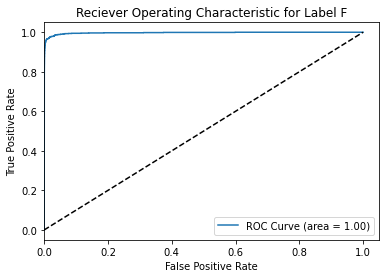

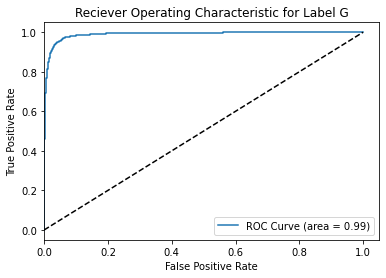

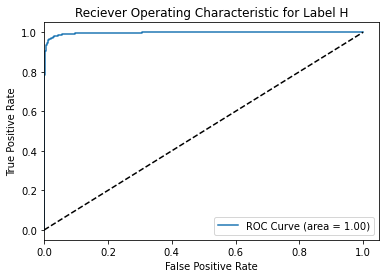

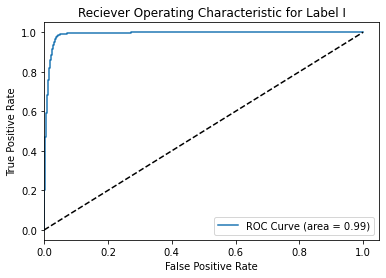

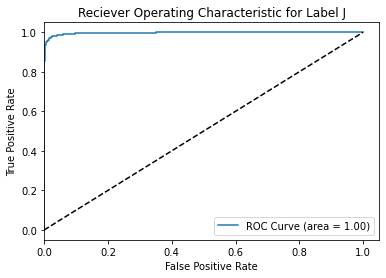

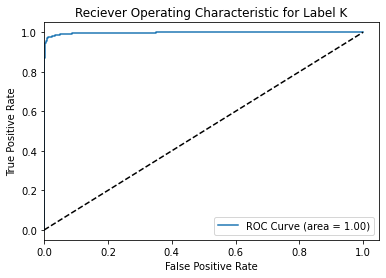

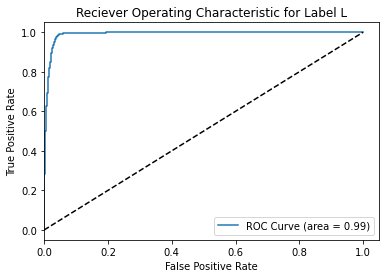

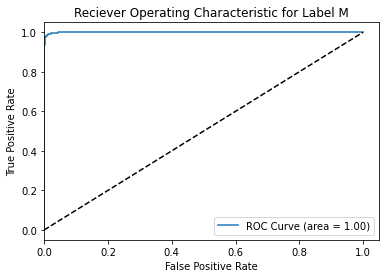

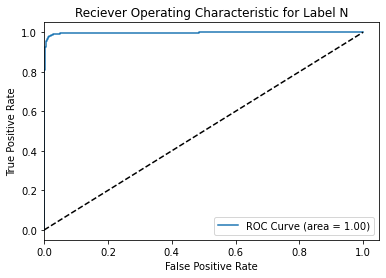

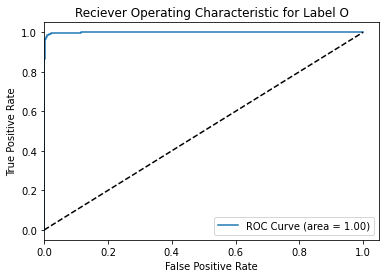

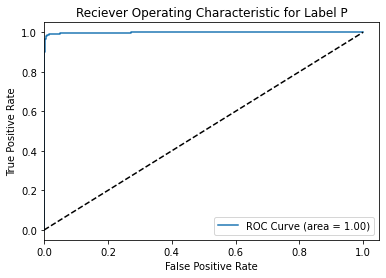

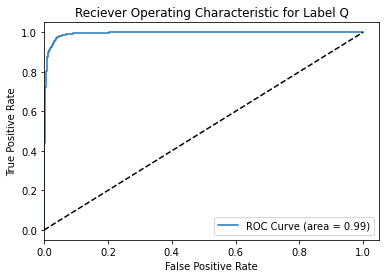

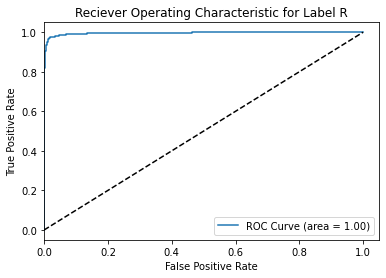

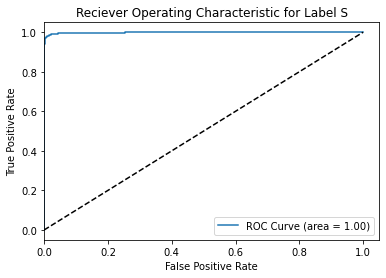

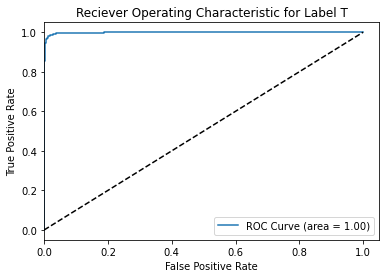

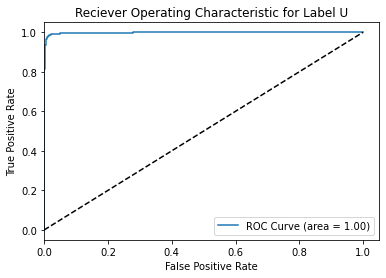

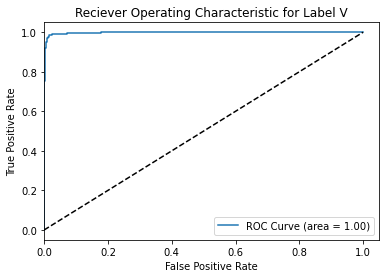

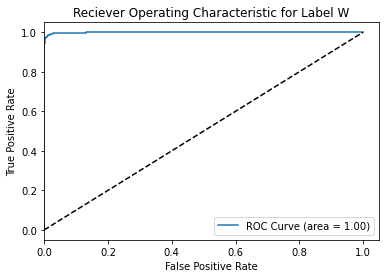

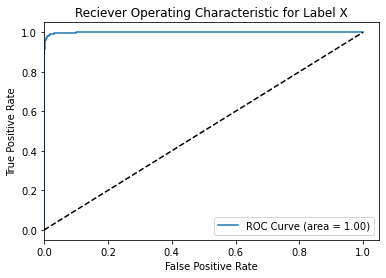

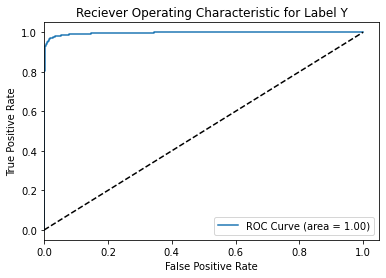

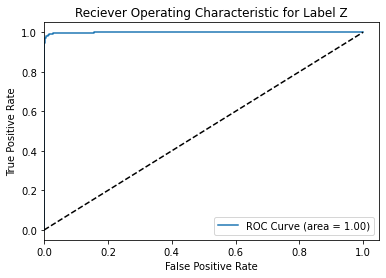

In [55]:
roc_auc(y_test_letter_ohe, nn_letter_predicted, num_classes)

# Letter and Digit Data

In [56]:
# Prepare digit data to be normalized with letter data
X_num_data = X_train_num * 255

# Make letter labels correspond to numbers 10-36
letter_df2 = pd.DataFrame(X_letter2)
letter_df2['Label'] = y_letter + 10
first_col = letter_df2.pop('Label')
letter_df2.insert(0, 'Label', first_col)
letter_df2

num_df = pd.DataFrame(X_num_data)
num_df['Label'] = y_train_num
first_col = num_df.pop('Label')
num_df.insert(0, 'Label', first_col)
num_df

Label    0    1    2    3    4    5    6    7    8  ...  774  775  776  \
0          5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1          0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2          4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3          1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4          9  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
59995      8  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
59996      3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
59997      5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
59998      6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
59999      8  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

       777  778  779  780  781  782  783  
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...    ...  ...  ...  ...  ...  ...  ...  
59995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
59996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
59997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
59998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
59999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[60000 rows x 785 columns]

In [57]:
df = pd.concat([num_df, letter_df2])
df

Label    0    1    2    3    4    5    6    7    8  ...  774  775  776  \
0          5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1          0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2          4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3          1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4          9  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
88794     10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
88795     30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
88796     10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
88797     32  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
88798     21  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

       777  778  779  780  781  782  783  
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...    ...  ...  ...  ...  ...  ...  ...  
88794  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
88795  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
88796  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
88797  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
88798  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[148799 rows x 785 columns]

In [58]:
y = df.pop('Label')
X = df

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)

In [60]:
X_train = np.array(X_train.iloc[:, 0:].values)
y_train = np.array(y_train)

X_test = np.array(X_test.iloc[:, 0:].values)
y_test = np.array(y_test)

X_train /= 255
X_test /= 255

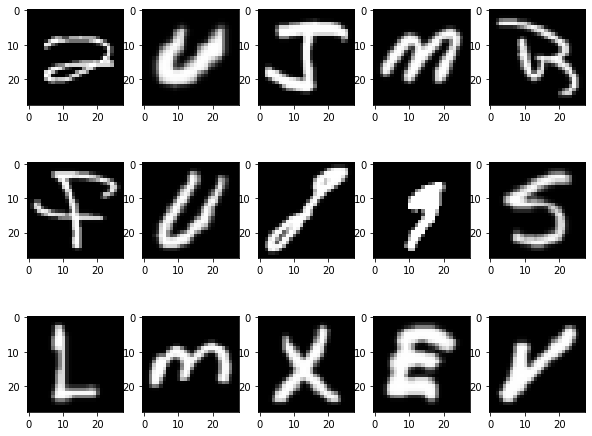

In [61]:
fig, axes = plt.subplots(3, 5, figsize=(10,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape([28,28]), cmap=plt.get_cmap('gray'))

In [62]:
characters = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H',
           'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

y_train2 = []
y_test2 = []

for character in y_train:
    y_train2.append(characters[character])
    
for character in y_test:
    y_test2.append(characters[character])

y_train2

['2',
 'U',
 'J',
 'M',
 'B',
 'F',
 'U',
 'G',
 '9',
 'S',
 'L',
 'M',
 'X',
 'E',
 'V',
 'W',
 '2',
 'B',
 'A',
 '9',
 'P',
 '9',
 'Y',
 '3',
 '4',
 '1',
 'F',
 '8',
 'U',
 '4',
 '5',
 '5',
 '6',
 '0',
 'V',
 '1',
 '2',
 'J',
 '9',
 'Y',
 '6',
 '3',
 '3',
 '9',
 'B',
 '8',
 'N',
 'S',
 'Y',
 '8',
 'U',
 'H',
 'K',
 'N',
 '3',
 'T',
 '3',
 'U',
 'C',
 'E',
 'O',
 'W',
 'T',
 'D',
 '4',
 'J',
 'B',
 '9',
 'O',
 'G',
 'C',
 'L',
 '0',
 '2',
 'L',
 'G',
 'E',
 'C',
 'E',
 'I',
 '6',
 '2',
 'J',
 '4',
 'X',
 'N',
 'N',
 'H',
 '1',
 'L',
 '6',
 '6',
 '6',
 'Q',
 'N',
 '9',
 '1',
 '1',
 '8',
 '5',
 'N',
 'R',
 'E',
 'H',
 '8',
 '3',
 'E',
 '7',
 'Q',
 'G',
 'M',
 '9',
 '8',
 '6',
 '7',
 'N',
 'E',
 'T',
 'Z',
 'Z',
 '6',
 'J',
 '7',
 '2',
 'K',
 'A',
 'W',
 '1',
 'G',
 '0',
 'E',
 '0',
 '5',
 '1',
 '4',
 'C',
 'O',
 '8',
 '1',
 'I',
 '6',
 'K',
 'L',
 'U',
 '1',
 '1',
 'Z',
 'G',
 '5',
 'O',
 'J',
 'Y',
 '1',
 'Y',
 'V',
 'L',
 'Z',
 '8',
 '0',
 '2',
 '6',
 '5',
 '5',
 'U',
 '4',
 'X',
 '2'

In [63]:
y_train_ohe = np_utils.to_categorical(y_train)
y_test_ohe = np_utils.to_categorical(y_test)

num_classes = y_test_ohe.shape[1]
num_classes

36

## K-Nearest Neighbors

In [64]:
knn = KNeighborsClassifier(n_jobs=3)
knn.fit(X_train, y_train2) #y_train_ohe

KNeighborsClassifier(n_jobs=3)

In [65]:
knn_predicted = knn.predict(X_test)

In [67]:
print('Accuracy: ', accuracy_score(y_test2, knn_predicted))

Accuracy:  0.8743890518084066


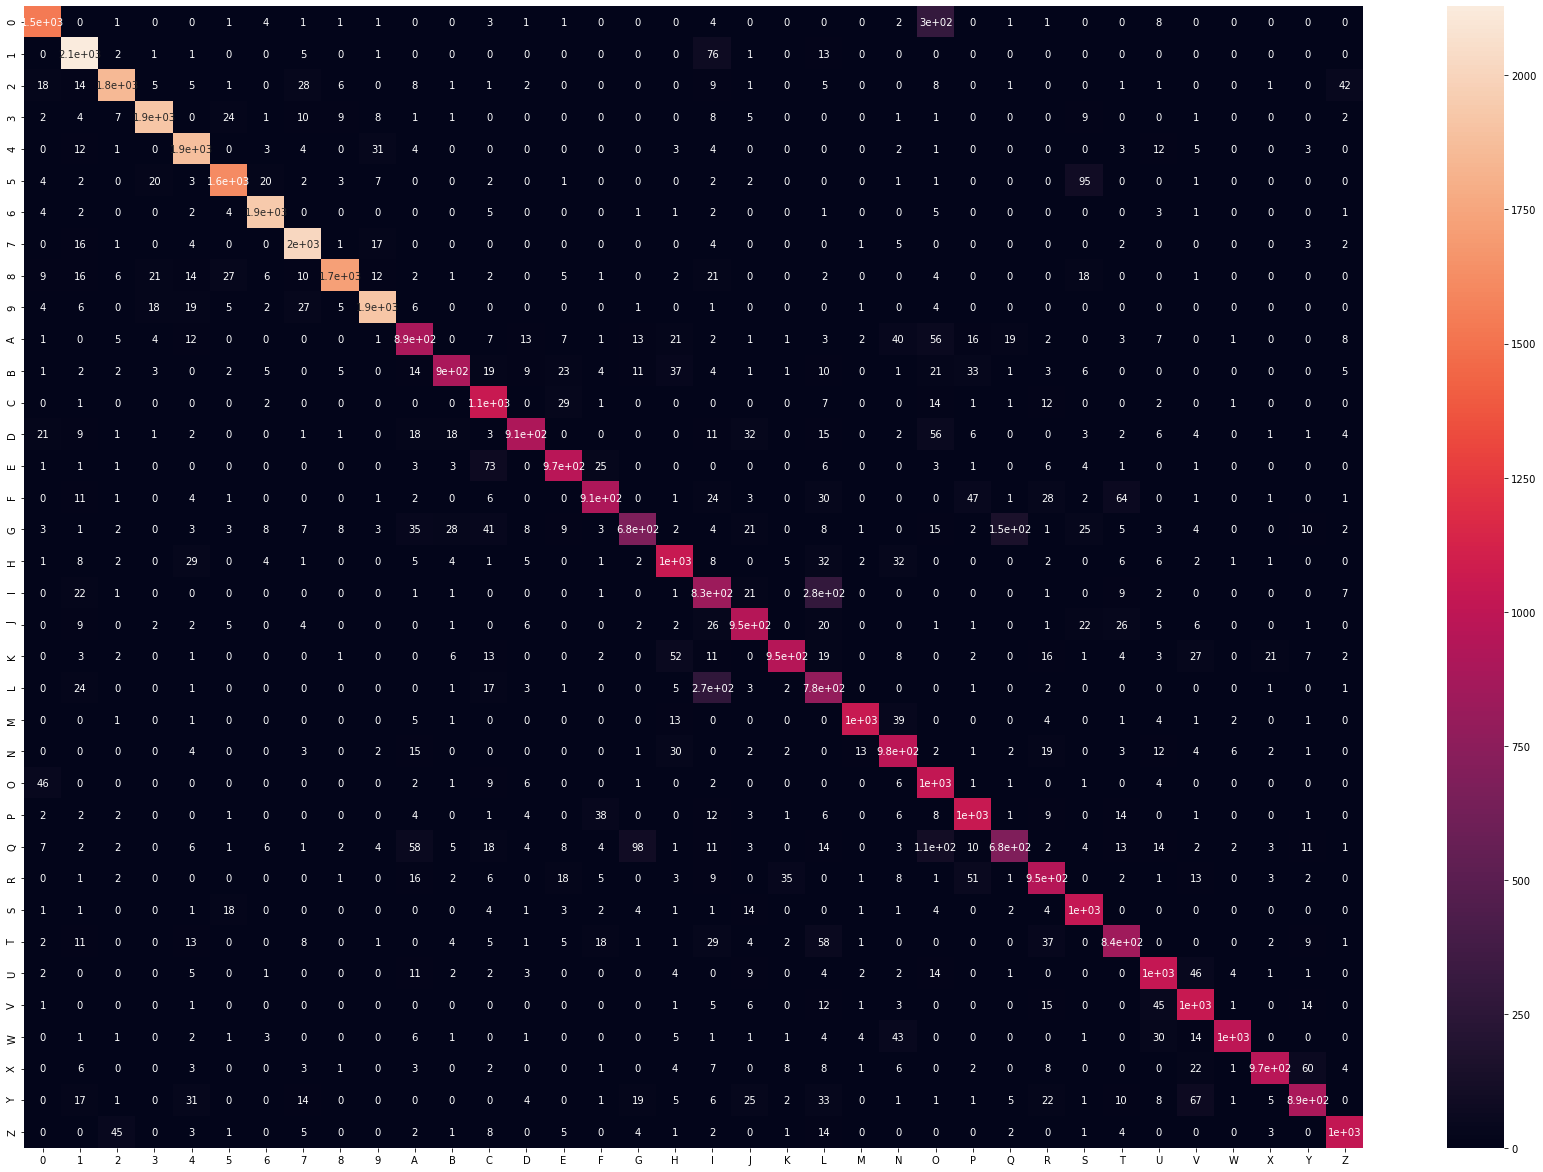

In [70]:
axis_labels = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

create_confusion(y_test2, knn_predicted, axis_labels)

C:\Users\Patrick\anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


One-vs-One ROC AUC scores:
0.928873 (macro), 
0.935504 (weighted)

One-vs-Rest ROC AUC scores:
0.928873 (macro), 
0.935504 (weighted)


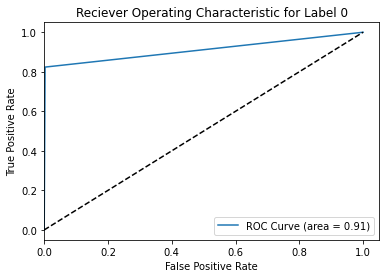

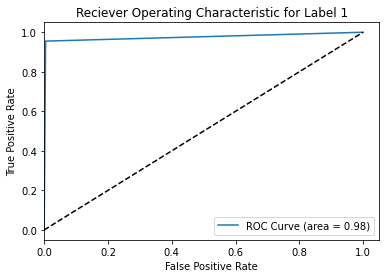

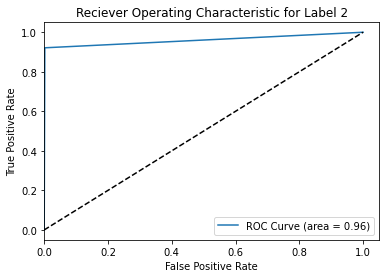

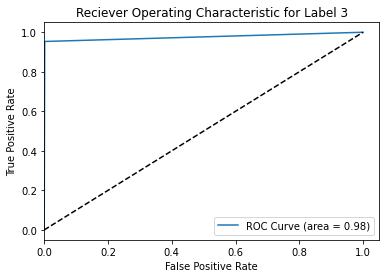

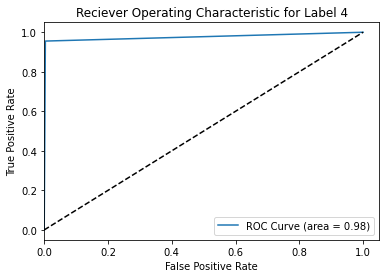

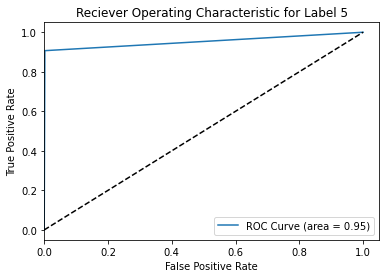

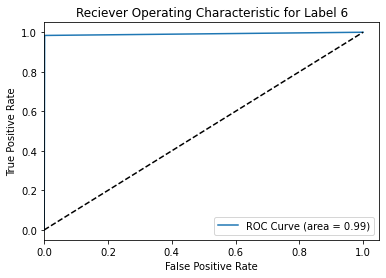

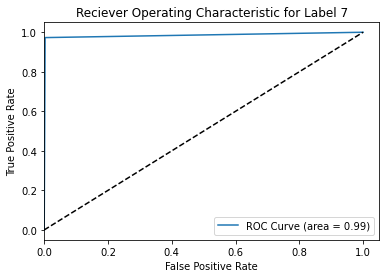

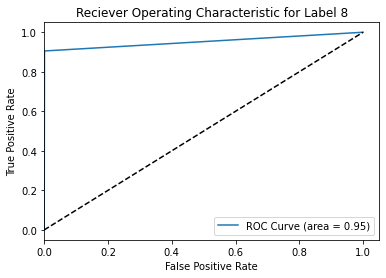

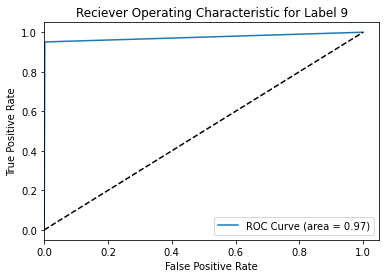

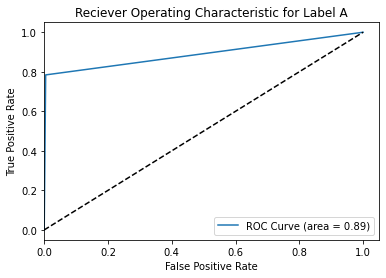

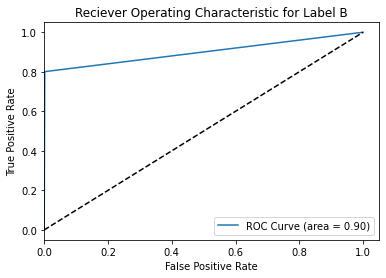

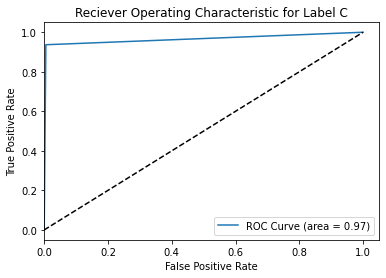

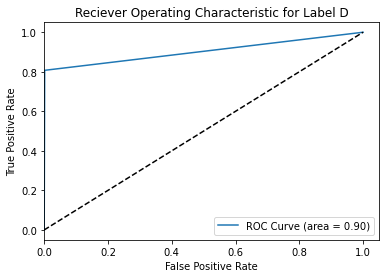

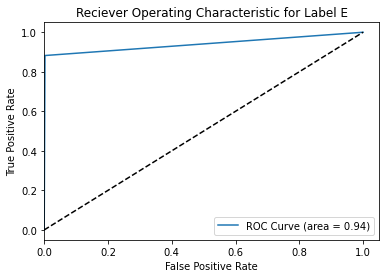

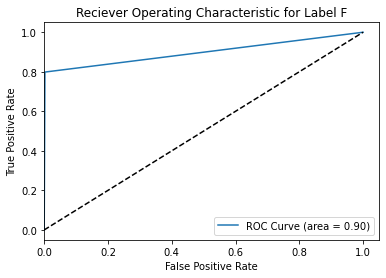

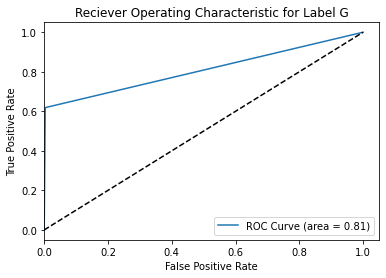

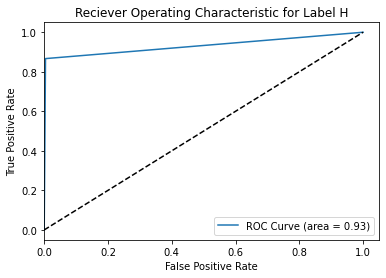

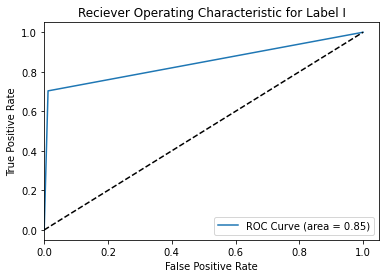

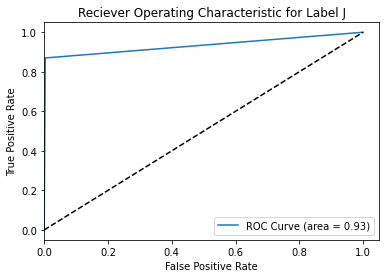

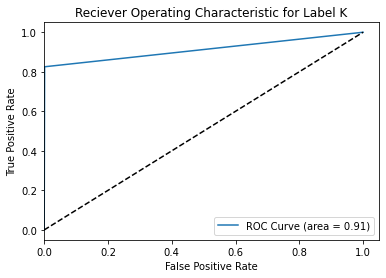

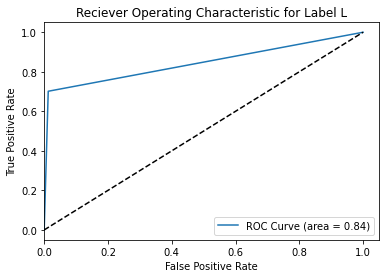

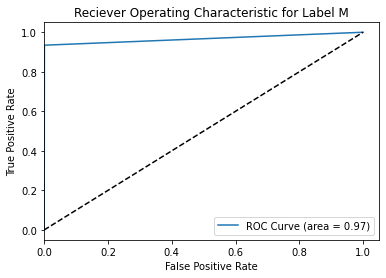

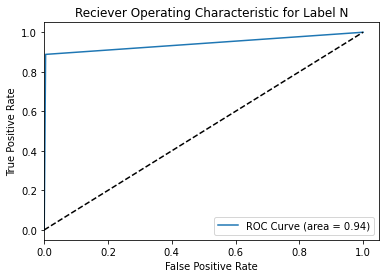

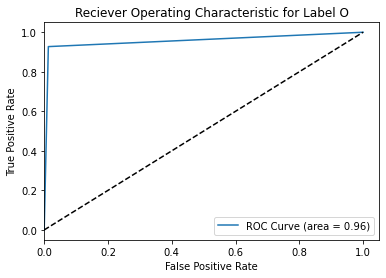

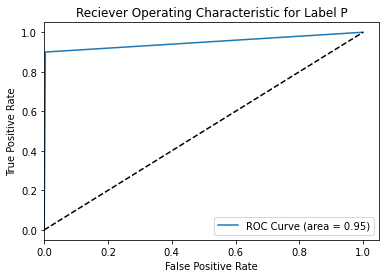

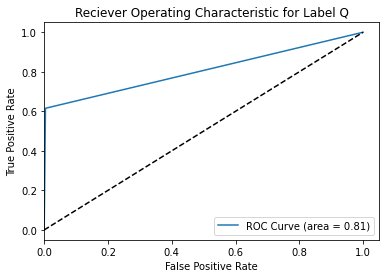

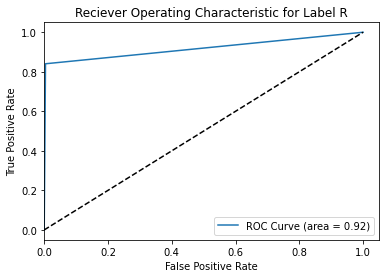

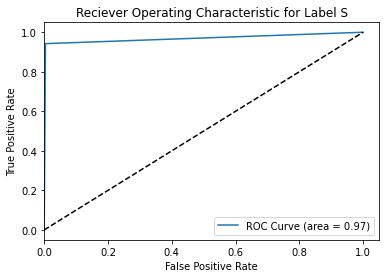

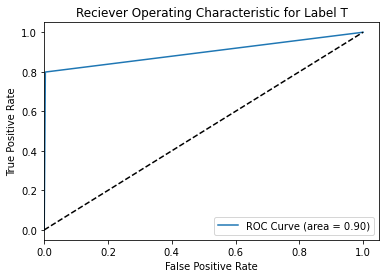

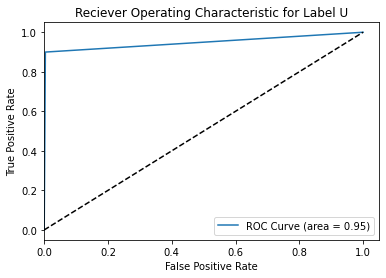

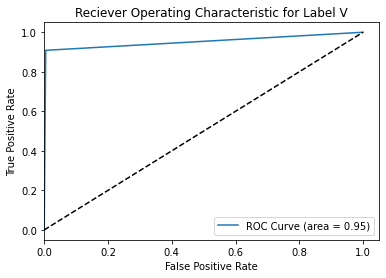

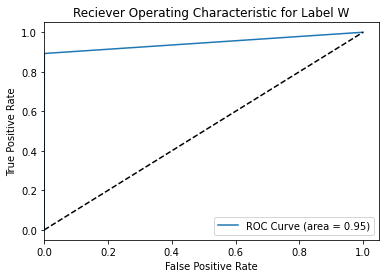

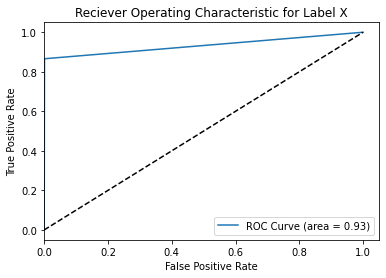

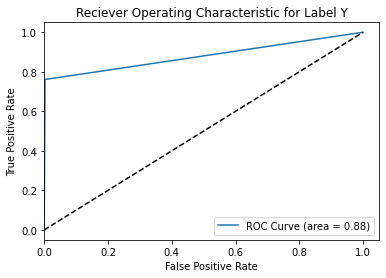

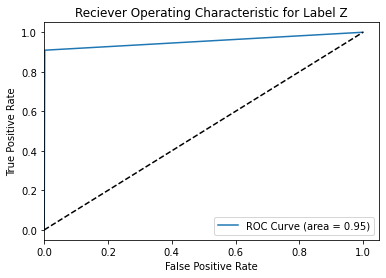

In [105]:
knn_categorical = []

# Get ASCII for each character in order to make range 0-35
for character in knn_predicted:
    int_check = False
    try:
        knn_categorical.append(int(character))
    except ValueError: 
        knn_categorical.append(ord(character) - 55)
        
knn_categorical = np_utils.to_categorical(knn_categorical)

roc_auc(y_test_ohe, knn_categorical, num_classes)

## Logistic Regression

In [106]:
logreg = LogisticRegression(max_iter=10000, n_jobs=3)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000, n_jobs=3)

In [107]:
logreg_predicted = logreg.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, logreg_predicted))

Accuracy:  0.7743157380254154


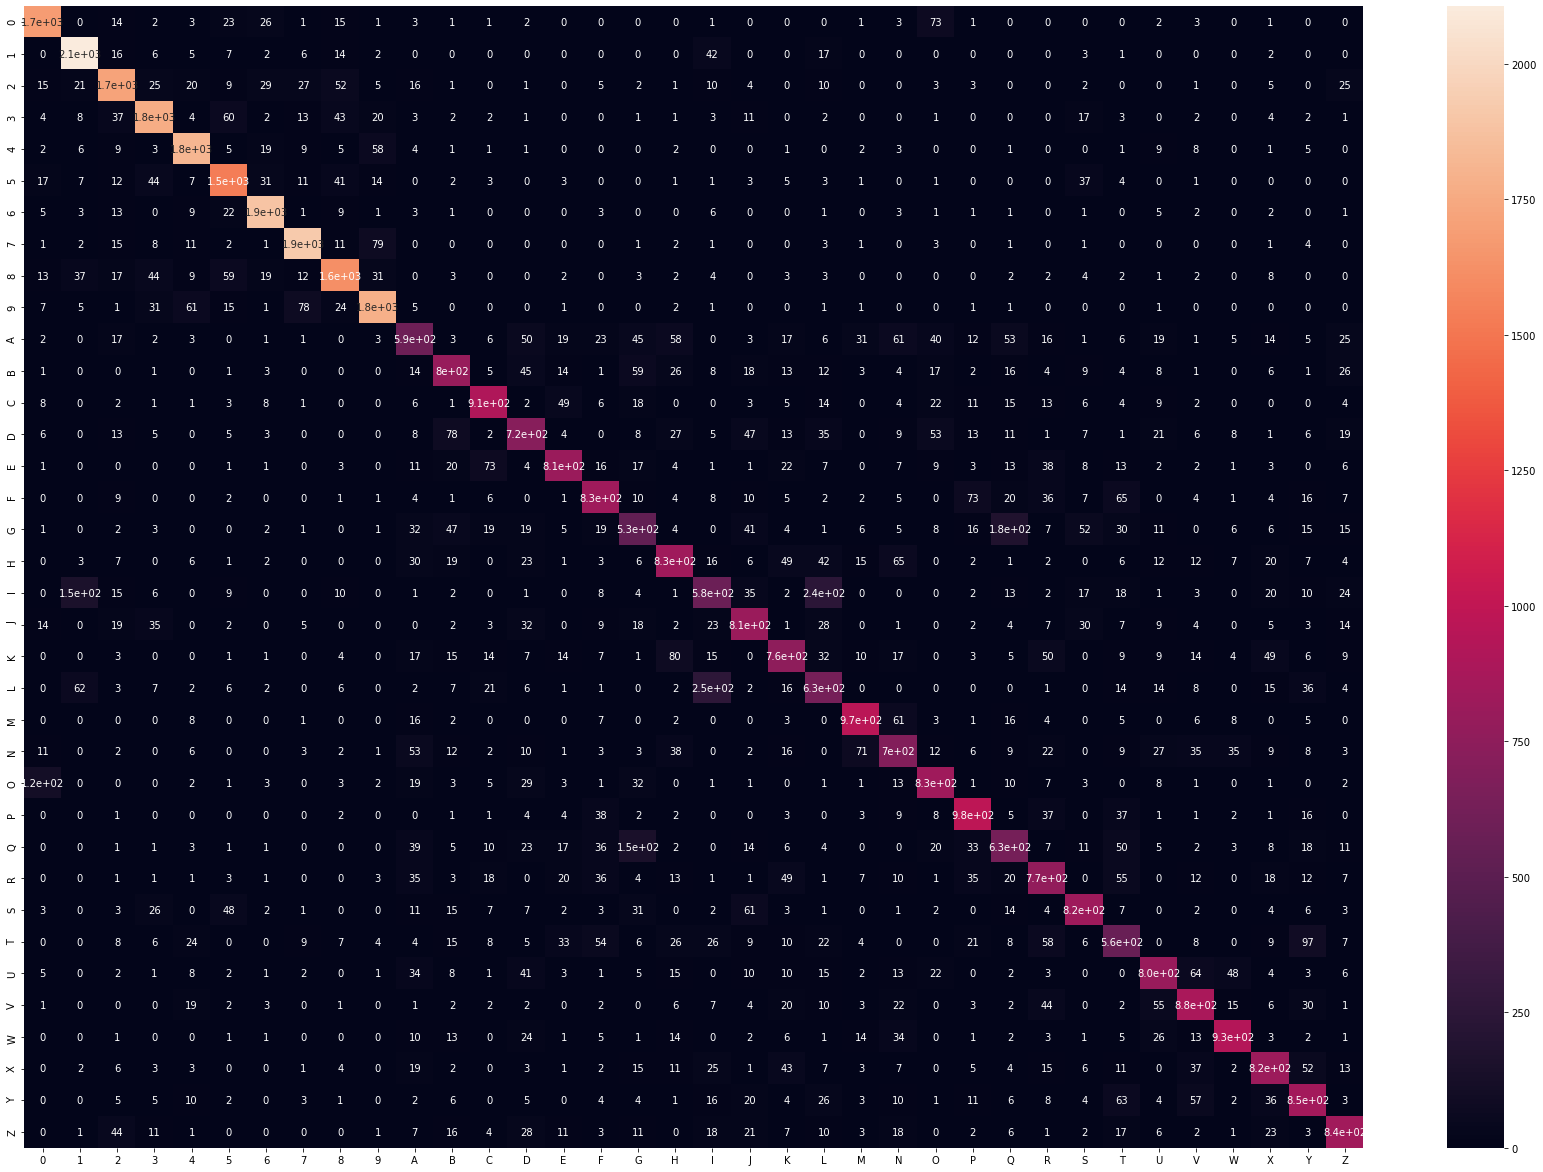

In [108]:
logreg_predicted_ohe = np_utils.to_categorical(logreg_predicted)

create_confusion(y_test_ohe, logreg_predicted_ohe, axis_labels)

C:\Users\Patrick\anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


One-vs-One ROC AUC scores:
0.870541 (macro), 
0.884039 (weighted)

One-vs-Rest ROC AUC scores:
0.870541 (macro), 
0.884039 (weighted)


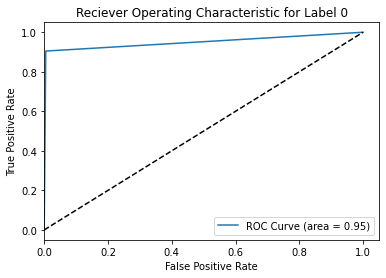

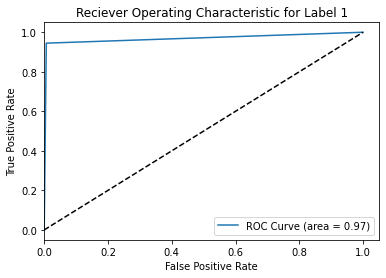

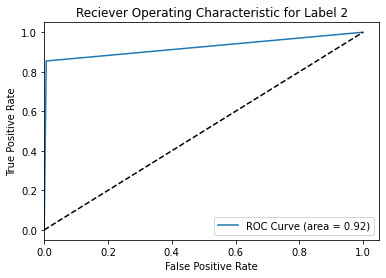

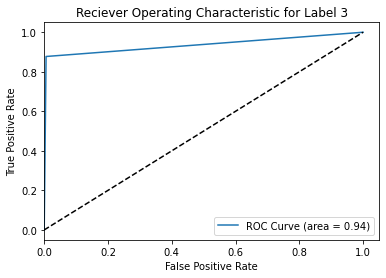

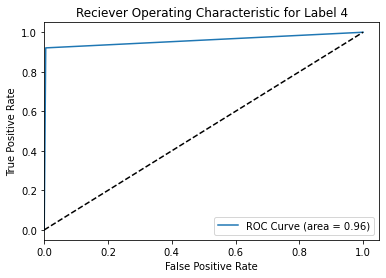

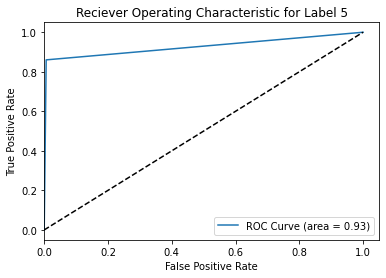

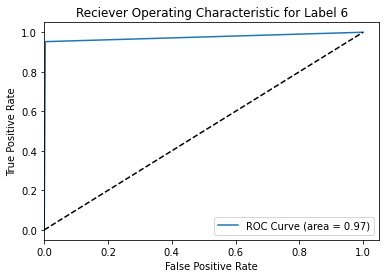

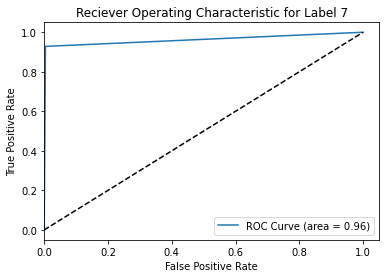

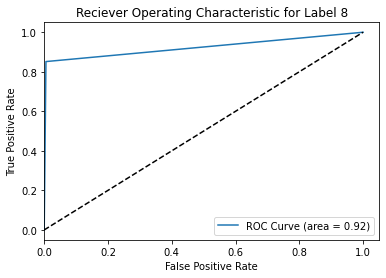

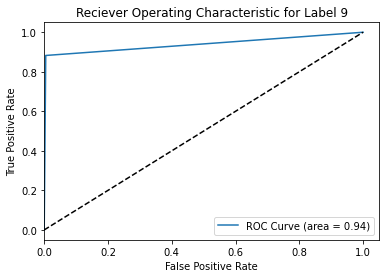

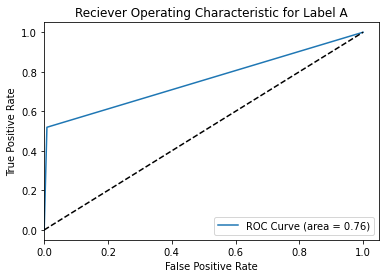

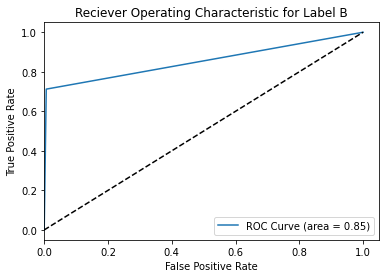

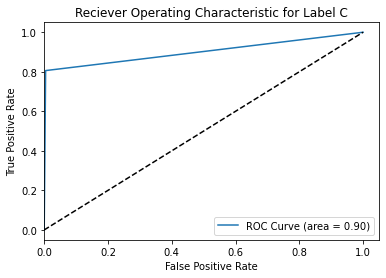

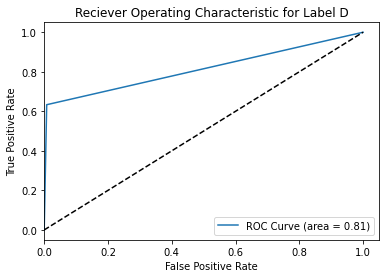

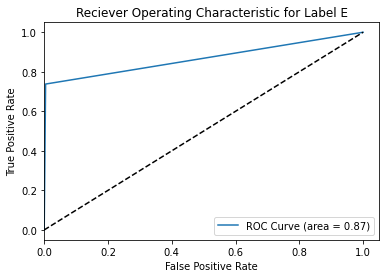

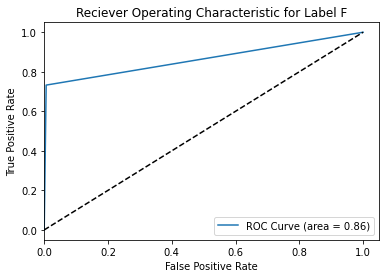

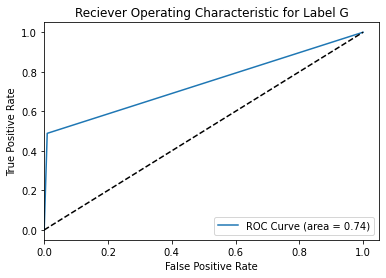

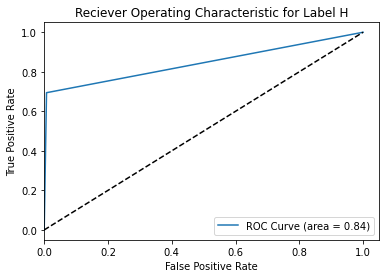

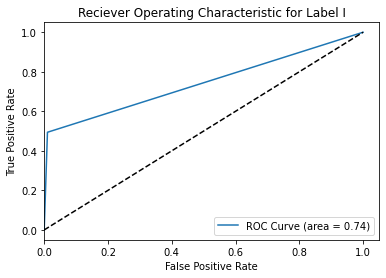

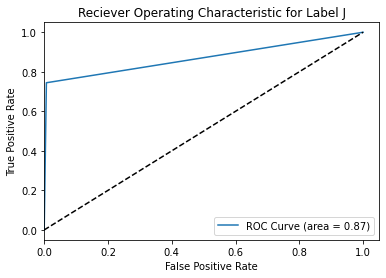

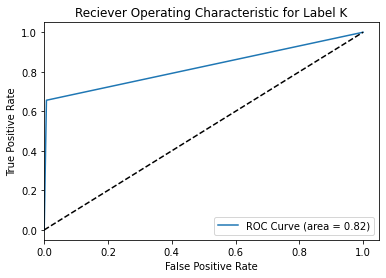

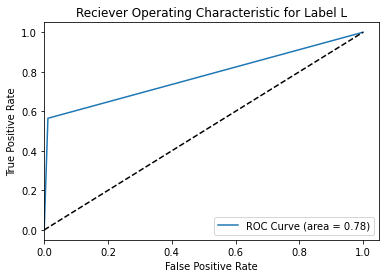

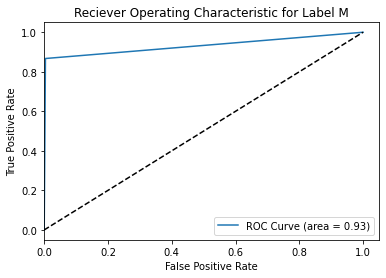

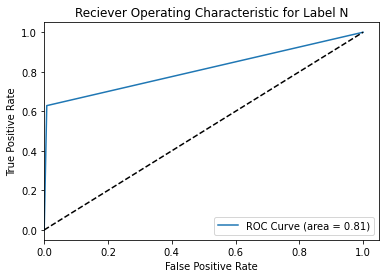

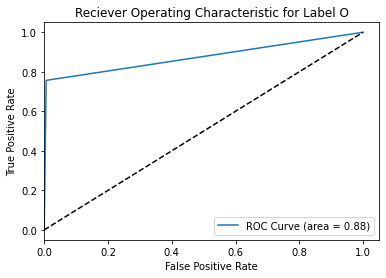

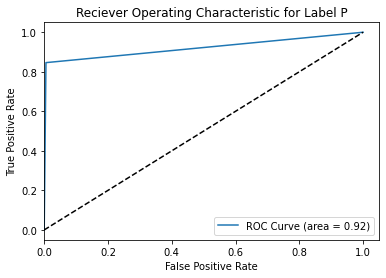

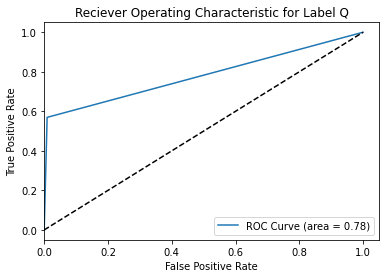

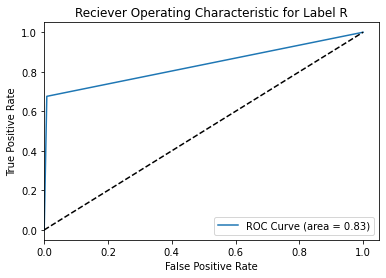

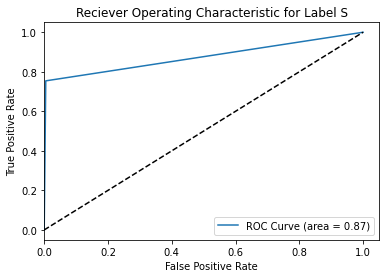

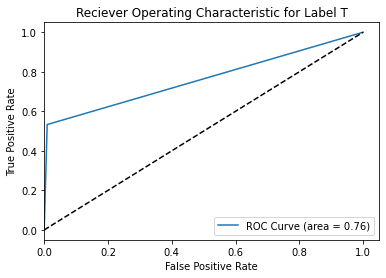

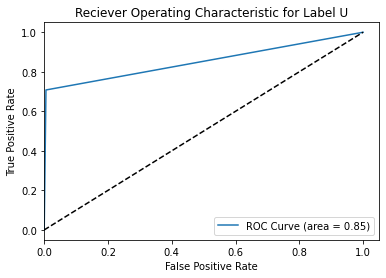

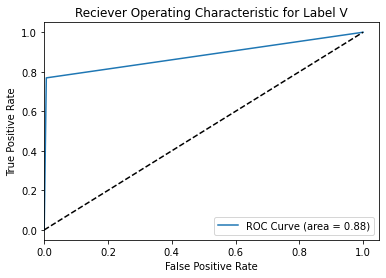

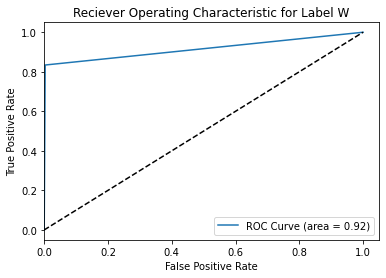

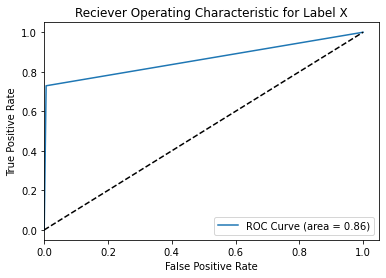

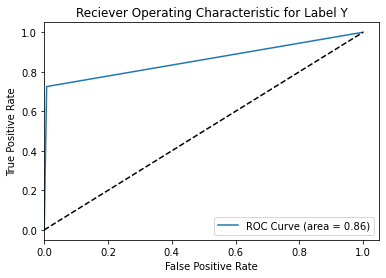

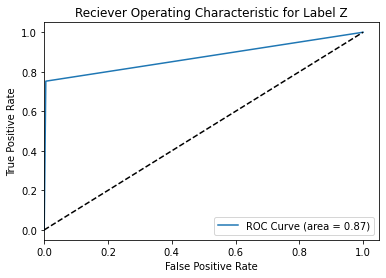

In [109]:
logreg_categorical = []

# Get ASCII for each character and subtract 48 in order to make range 0-35
for character in logreg_predicted:
    int_check = False
    try:
        logreg_categorical.append(int(character))
    except ValueError: 
        logreg_categorical.append(ord(character) - 55)

logreg_categorical = np_utils.to_categorical(logreg_categorical)

roc_auc(y_test_ohe, logreg_categorical, num_classes)

## Simple Neural Network

In [110]:
model = simple_nn(num_classes)
model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=10, batch_size=200, verbose=2)

accuracy = model.evaluate(X_test, y_test_ohe, verbose=0)
print('Accuracy: ', accuracy[1])

Train on 99695 samples, validate on 49104 samples
Epoch 1/10
 - 7s - loss: 0.7788 - accuracy: 0.7841 - val_loss: 0.4579 - val_accuracy: 0.8645
Epoch 2/10
 - 7s - loss: 0.3682 - accuracy: 0.8913 - val_loss: 0.3432 - val_accuracy: 0.8967
Epoch 3/10
 - 8s - loss: 0.2725 - accuracy: 0.9171 - val_loss: 0.2943 - val_accuracy: 0.9089
Epoch 4/10
 - 7s - loss: 0.2190 - accuracy: 0.9325 - val_loss: 0.2800 - val_accuracy: 0.9128
Epoch 5/10
 - 7s - loss: 0.1844 - accuracy: 0.9417 - val_loss: 0.2656 - val_accuracy: 0.9159
Epoch 6/10
 - 7s - loss: 0.1562 - accuracy: 0.9498 - val_loss: 0.2615 - val_accuracy: 0.9179
Epoch 7/10
 - 7s - loss: 0.1345 - accuracy: 0.9564 - val_loss: 0.2489 - val_accuracy: 0.9232
Epoch 8/10
 - 7s - loss: 0.1166 - accuracy: 0.9617 - val_loss: 0.2532 - val_accuracy: 0.9246
Epoch 9/10
 - 7s - loss: 0.1021 - accuracy: 0.9660 - val_loss: 0.2516 - val_accuracy: 0.9236
Epoch 10/10
 - 7s - loss: 0.0911 - accuracy: 0.9694 - val_loss: 0.2563 - val_accuracy: 0.9241
Accuracy:  0.924079

In [111]:
nn_predicted = model.predict(X_test, batch_size=200, verbose=2)
print('Accuracy: ', accuracy_score(y_test, np.argmax(nn_predicted, axis=1)))

Accuracy:  0.924079504724666


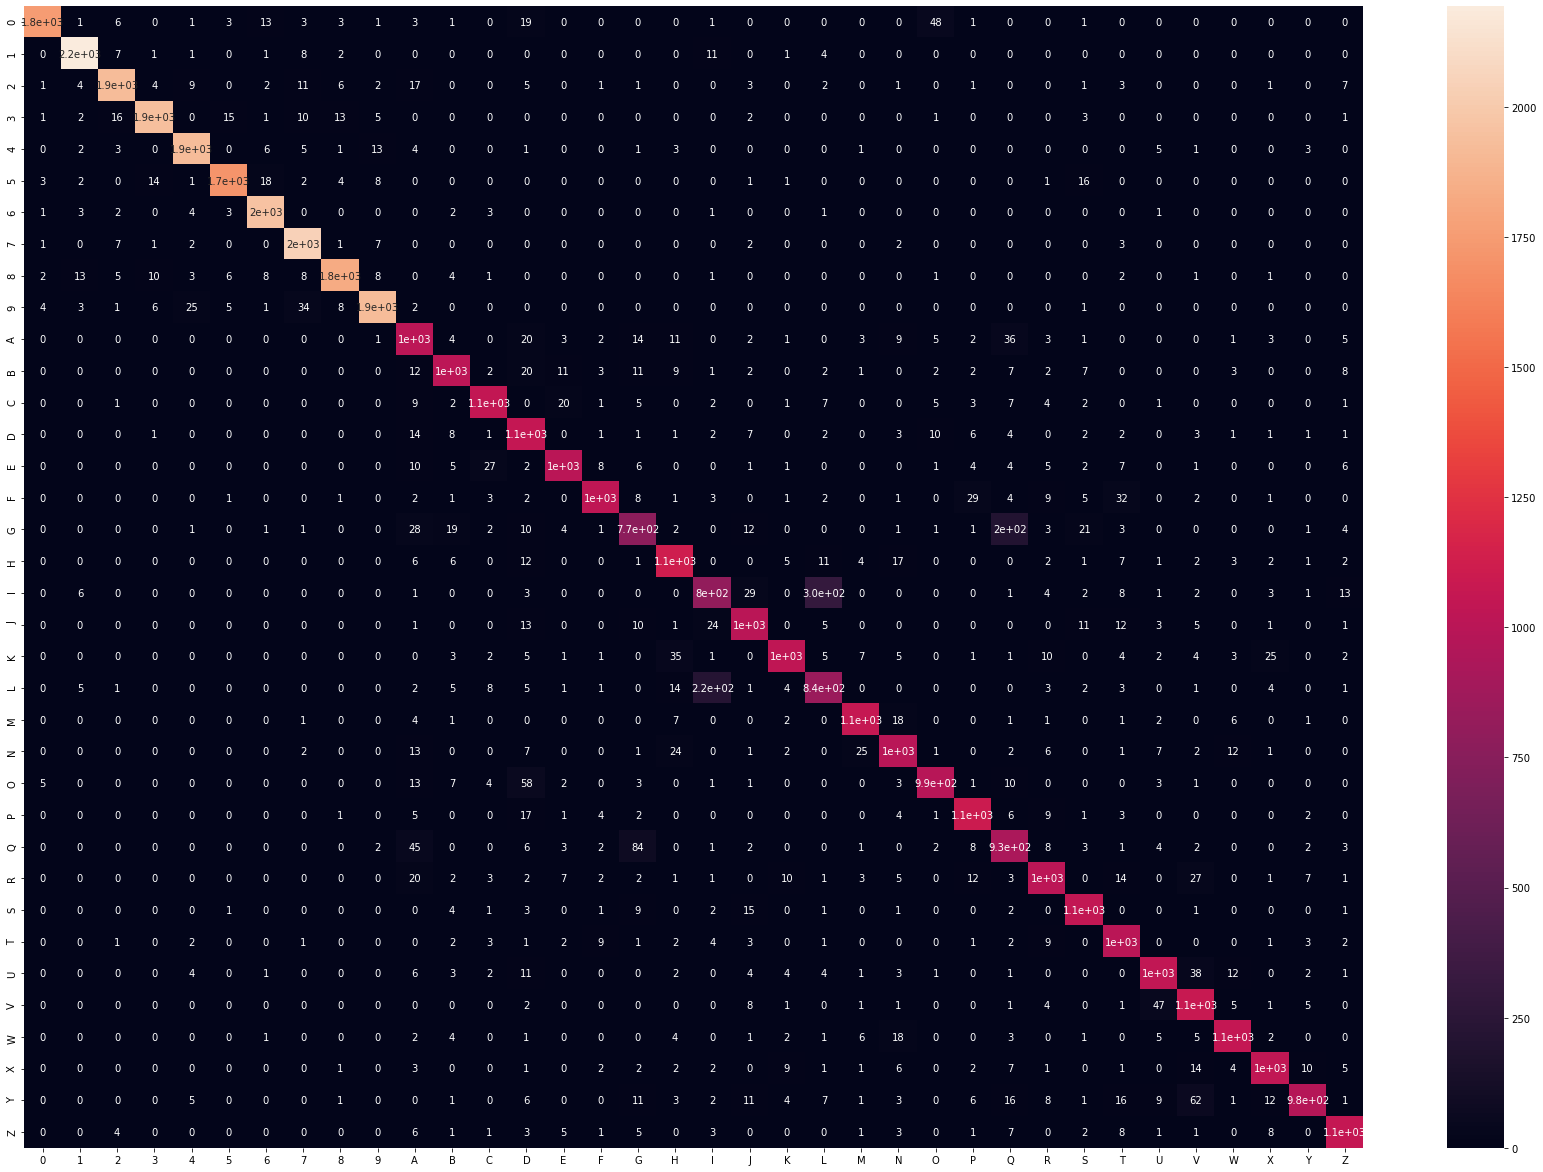

In [112]:
axis_labels = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
create_confusion(y_test_ohe, nn_predicted, axis_labels)

C:\Users\Patrick\anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


One-vs-One ROC AUC scores:
0.998260 (macro), 
0.998517 (weighted)

One-vs-Rest ROC AUC scores:
0.998260 (macro), 
0.998517 (weighted)


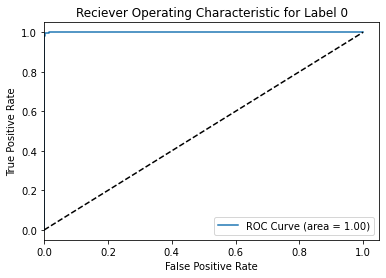

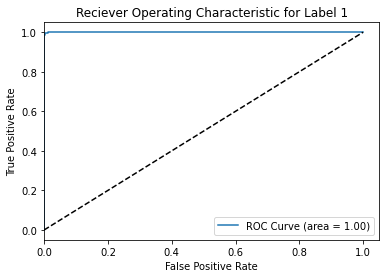

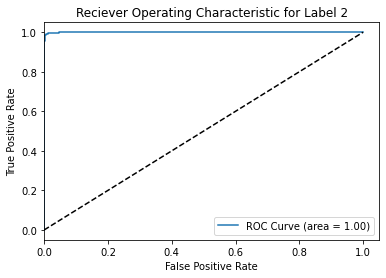

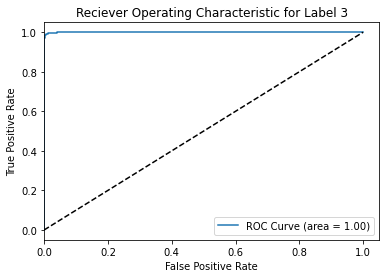

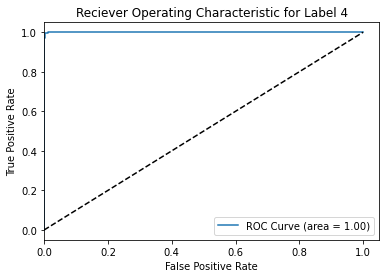

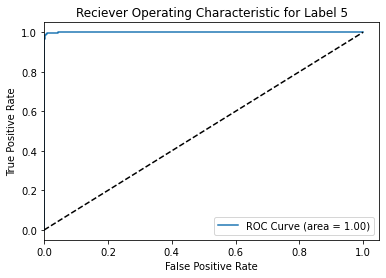

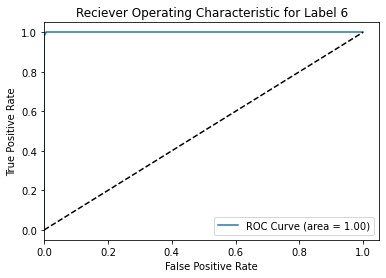

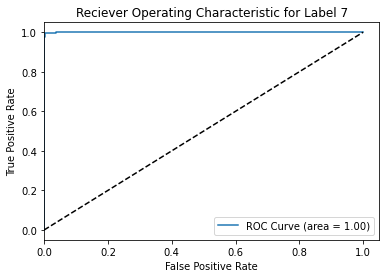

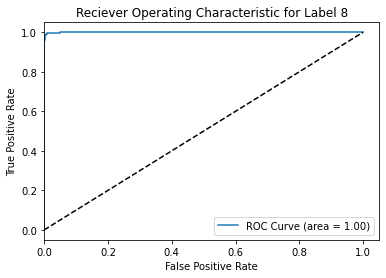

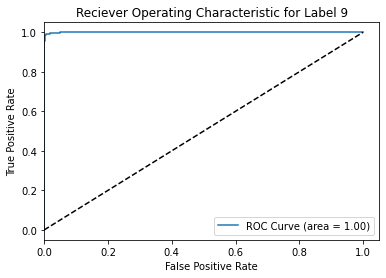

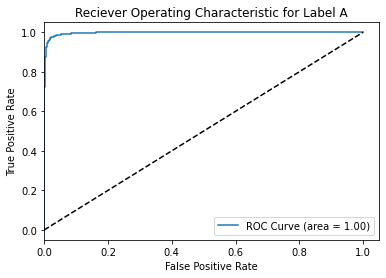

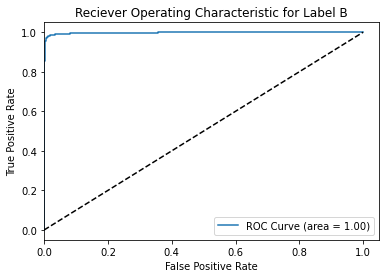

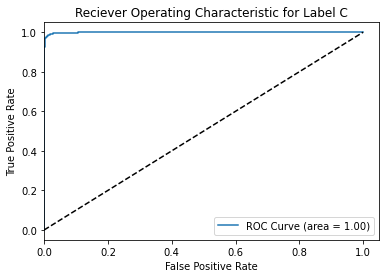

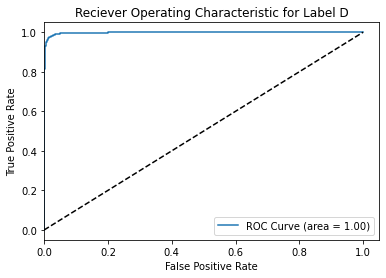

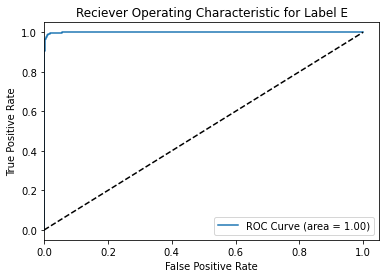

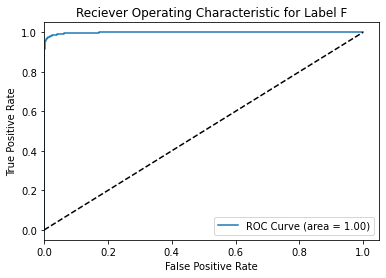

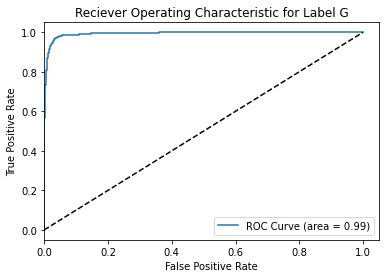

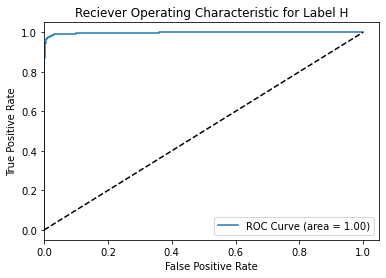

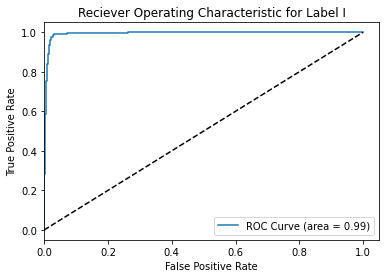

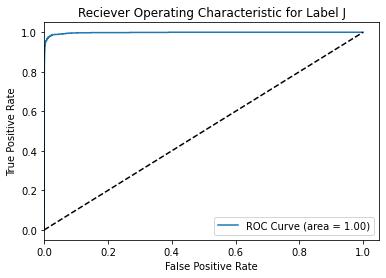

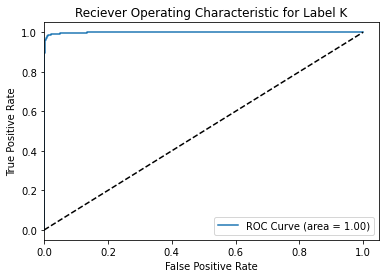

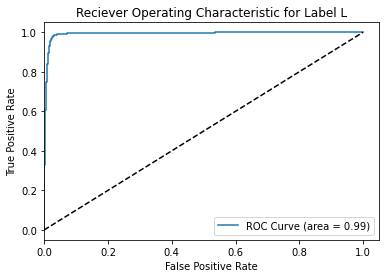

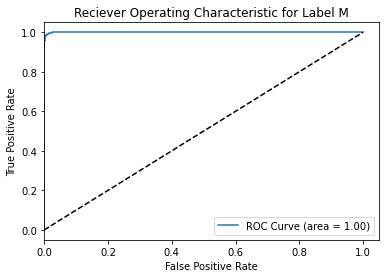

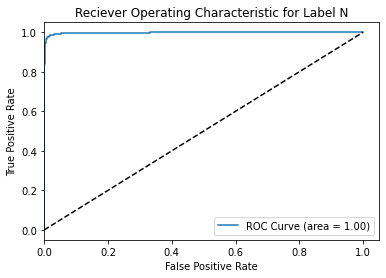

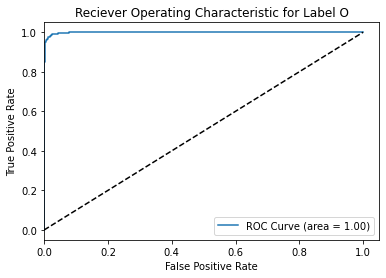

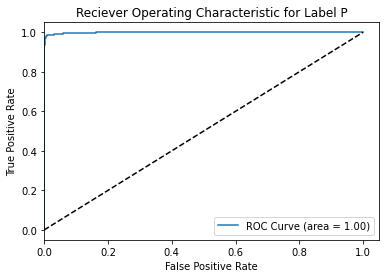

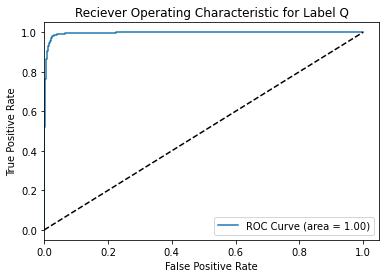

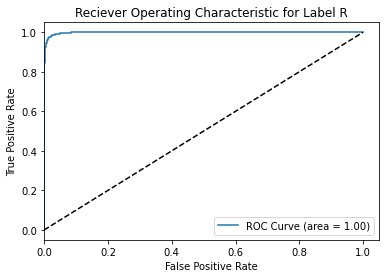

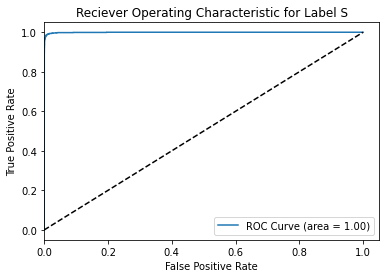

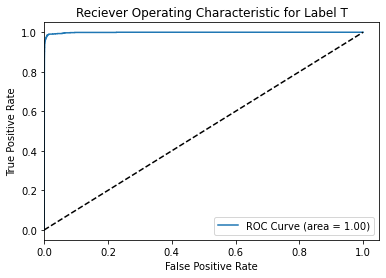

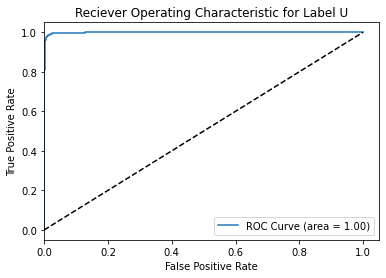

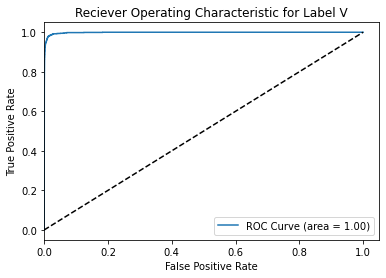

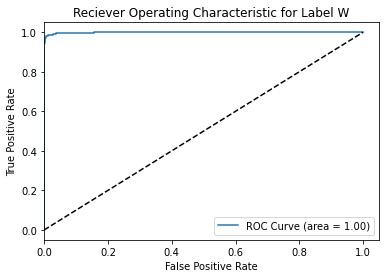

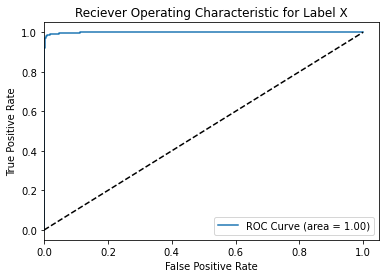

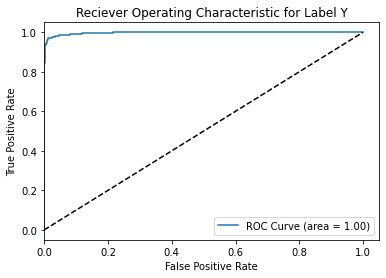

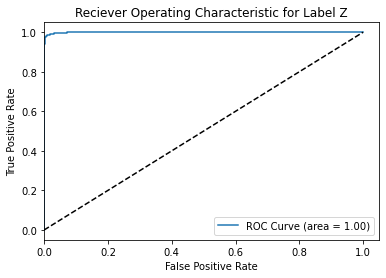

In [113]:
roc_auc(y_test_ohe, nn_predicted, num_classes)

# Image Processing

<function matplotlib.pyplot.show(close=None, block=None)>

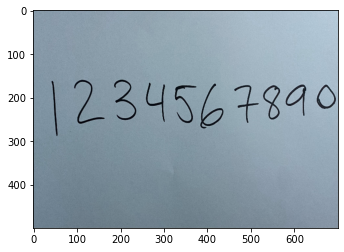

In [153]:
image = cv2.imread('number_test4.jpg')
image = cv2.resize(image, (700, 500))
plt.imshow(image, cmap='gray')
plt.show

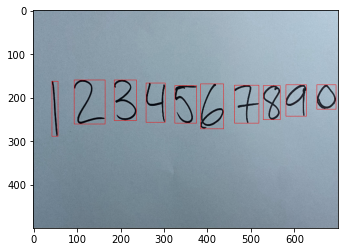

In [154]:
data1, df = process_image('number_test4.jpg')

In [155]:
nn_predicted1 = model.predict(data1, batch_size=200, verbose=2)
np.argmax(nn_predicted1, axis=1)

array([ 1,  2,  3,  4,  5,  6,  3,  8, 16,  0], dtype=int64)

In [156]:
predicted_characters(nn_predicted1)

['1', '2', '3', '4', '5', '6', '3', '8', 'G', '0']

In [157]:
knn_predicted1 = knn.predict(data1)
knn_predicted1

array(['I', '1', '3', '4', '5', '5', '1', '8', '4', '0'], dtype='<U1')

In [162]:
logreg_predicted1 = logreg.predict(data1)
predicted_characters(np_utils.to_categorical(logreg_predicted1))

['1', 'I', '3', '7', '2', '5', '1', '2', '9', '0']

<function matplotlib.pyplot.show(close=None, block=None)>

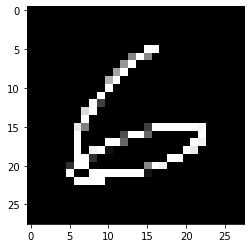

In [169]:
digits = data1.reshape(10, 28, 28)
plt.imshow(digits[5], cmap='gray')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

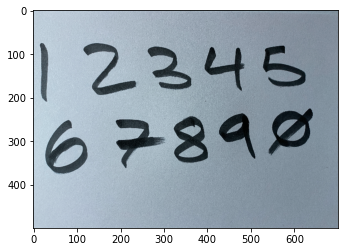

In [142]:
image = cv2.imread('number_test_rows.jpg')
image = cv2.resize(image, (700, 500))
plt.imshow(image, cmap='gray')
plt.show

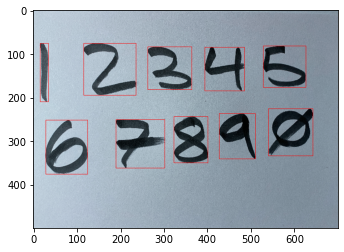

In [143]:
data2, df = process_image('number_test_rows.jpg')

In [144]:
nn_predicted2 = model.predict(data2, batch_size=200, verbose=2)
np.argmax(nn_predicted2, axis=1)

array([23,  2,  2,  4,  5,  6, 35,  8, 16,  3], dtype=int64)

In [145]:
predicted_characters(nn_predicted2)

['N', '2', '2', '4', '5', '6', 'Z', '8', 'G', '3']

In [146]:
knn_predicted2 = knn.predict(data2)
knn_predicted2

array(['O', 'Z', '2', '4', 'S', '6', 'T', '8', 'G', 'Z'], dtype='<U1')

In [163]:
logreg_predicted2 = logreg.predict(data2)
predicted_characters(np_utils.to_categorical(logreg_predicted2))

['X', '2', '2', '4', '5', '4', 'T', '8', '9', '9']

<function matplotlib.pyplot.show(close=None, block=None)>

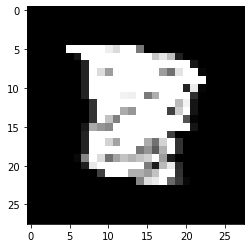

In [206]:
digits = data2.reshape(10, 28, 28)
plt.imshow(digits[0], cmap='gray')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

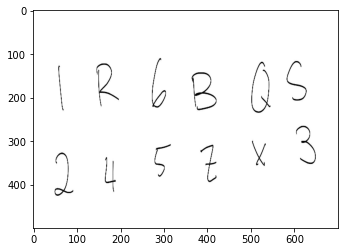

In [164]:
image = cv2.imread('letters and numbers test.jpg')
image = cv2.resize(image, (700, 500))
plt.imshow(image, cmap='gray')
plt.show

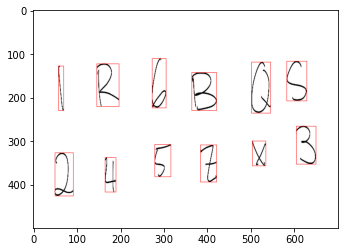

In [166]:
data3, df = process_image('letters and numbers test.jpg')

In [167]:
knn_predicted3 = knn.predict(data3)
knn_predicted3

array(['I', '1', 'I', '1', '1', '1', '1', '4', '1', '1', '1', '1'],
      dtype='<U1')

In [168]:
logreg_predicted3 = logreg.predict(data3)
predicted_characters(np_utils.to_categorical(logreg_predicted3))

['4', 'Y', '5', '2', '0', '5', '2', '4', '2', '5', '4', '1']

In [177]:
nn_predicted3 = model.predict(data3)
predicted_characters(nn_predicted3)

['1', '1', 'C', '2', '0', '5', '2', '4', '5', '3', 'X', '3']

<function matplotlib.pyplot.show(close=None, block=None)>

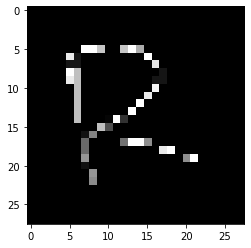

In [180]:
digits = data3.reshape(12, 28, 28)
plt.imshow(digits[1], cmap='gray')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

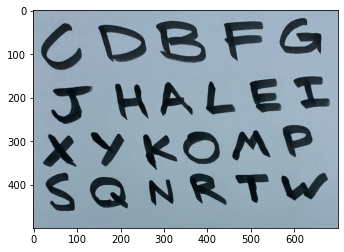

In [186]:
image = cv2.imread('letters_test.JPEG')
image = cv2.resize(image, (700, 500))
plt.imshow(image, cmap='gray')
plt.show

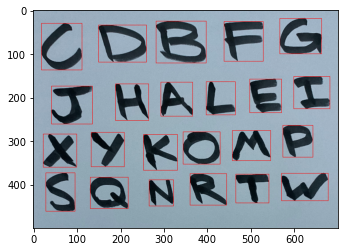

In [187]:
data6, df = process_image('letters_test.JPEG')

In [188]:
knn_letter_predicted = knn_letter.predict(data6)
knn_letter_predicted

array(['C', 'O', 'E', 'F', 'S', 'S', 'H', 'A', 'L', 'S', 'Z', 'X', 'Y',
       'R', 'O', 'N', 'P', 'S', 'A', 'H', 'K', 'T', 'V'], dtype='<U1')

In [190]:
logreg_letter_predicted = logreg_letter.predict(data6)
logreg_letter_predicted

array(['C', 'D', 'Z', 'F', 'S', 'S', 'B', 'K', 'U', 'E', 'S', 'X', 'Y',
       'T', 'O', 'N', 'P', 'S', 'G', 'N', 'X', 'Y', 'V'], dtype='<U1')

In [193]:
nn_letter_predicted = letter_model.predict(data6)
np.argmax(nn_letter_predicted, axis=1)

array([ 2,  3,  4,  5, 18,  9,  7,  0, 11,  4,  8, 23, 24, 10, 14, 13, 15,
       18,  0, 13, 25, 19, 22], dtype=int64)

In [199]:
np.array(predicted_letters(nn_letter_predicted))

array(['C', 'D', 'E', 'F', 'S', 'J', 'H', 'A', 'L', 'E', 'I', 'X', 'Y',
       'K', 'O', 'N', 'P', 'S', 'A', 'N', 'Z', 'T', 'W'], dtype='<U1')

<function matplotlib.pyplot.show(close=None, block=None)>

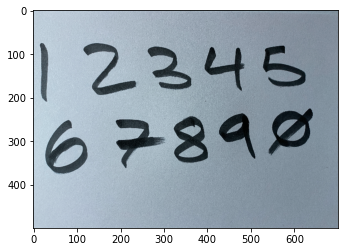

In [200]:
image = cv2.imread('number_test_rows.jpg')
image = cv2.resize(image, (700, 500))
plt.imshow(image, cmap='gray')
plt.show

In [202]:
knn_digit_predicted = knn_digit.predict(data2)
np.argmax(knn_digit_predicted, axis=1)

array([8, 2, 2, 4, 5, 6, 3, 8, 9, 2], dtype=int64)

In [203]:
logreg_digit_predicted = logreg_digit.predict(data2)
logreg_digit_predicted

array([9, 2, 2, 4, 5, 6, 9, 8, 9, 9], dtype=uint8)

In [205]:
nn_digit_predicted = digit_model.predict(data2)
np.argmax(nn_digit_predicted, axis=1)

array([8, 2, 2, 4, 5, 6, 7, 8, 9, 7], dtype=int64)

<function matplotlib.pyplot.show(close=None, block=None)>

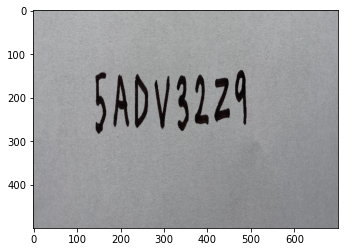

In [208]:
image = cv2.imread('wc_numbers_test.jfif')
image = cv2.resize(image, (700, 500))
plt.imshow(image, cmap='gray')
plt.show

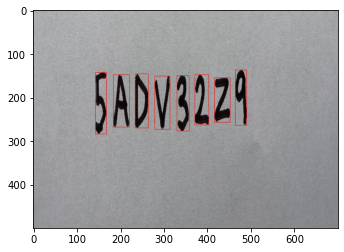

In [209]:
data7, df = process_image('wc_numbers_test.jfif')